# SurfaceFluxes_prescribed

In [1]:
import intake
import glob
import dask.distributed as dsk
import matplotlib.pyplot as plt
import xarray as xr
import cf_xarray as cfxr
import numpy as np
import xesmf as xe

import cmocean as cm
import cartopy.crs as ccrs

import cartopy.feature as cft
import matplotlib.path as mpath

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

In [2]:
from os import environ
environ["PYTHONWARNINGS"] = "ignore"

from dask.distributed import Client
client = Client(threads_per_worker = 1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/44987/status,
Dashboard: /proxy/44987/status,Workers: 28
Total threads: 28,Total memory: 126.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38731,Workers: 0
Dashboard: /proxy/44987/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:44563,Total threads: 1
Dashboard: /proxy/42155/status,Memory: 4.50 GiB
Nanny: tcp://127.0.0.1:41807,


In [3]:
# Colours
from matplotlib.colors import to_rgba

colors = {'pan01_res': '#0000a2',
          'pan005_res': '#E84141',
          'pan01_pre' : '#18669C',
          'access_pre': 'tab:orange'}

def lighten(color, amount=0.4):
    c = np.array(to_rgba(color))
    return tuple(c[:3] + (1 - c[:3]) * amount)

In [4]:
## All in fresh water fluxes
# ice_salt + restore_salt + wfo - runoff
pan_flux_C = xr.open_dataarray('/g/data/g40/kc5856/thesis_figures/data_files/surfaceflux_shelf_time_C_newtest_prescribed_pan01.nc')
pan_flux_M = xr.open_dataarray('/g/data/g40/kc5856/thesis_figures/data_files/surfaceflux_shelf_time_M_newtest_prescribed_pan01.nc')
acc_flux_C = xr.open_dataarray('/g/data/g40/kc5856/thesis_figures/data_files/surfaceflux_shelf_time_C_newtest_prescribed_ACCESS.nc')
acc_flux_M = xr.open_dataarray('/g/data/g40/kc5856/thesis_figures/data_files/surfaceflux_shelf_time_M_newtest_prescribed_ACCESS.nc')

In [5]:
pan_flux_C_new = pan_flux_C.to_series()
pan_flux_M_new = pan_flux_M.to_series()
acc_flux_C_new = acc_flux_C.to_series()
acc_flux_M_new = acc_flux_M.to_series()

pan_flux_C_new = pan_flux_C_new['2001-01-01':'2010-12-16']
pan_flux_M_new = pan_flux_M_new['2001-01-01':'2010-12-16']
acc_flux_C_new = acc_flux_C_new['1910-01-01':'1919-12-16']
acc_flux_M_new = acc_flux_M_new['1910-01-01':'1919-12-16']

# Reset index to normalized months
pan_flux_C_new.index = range(1, len(pan_flux_C_new)+1)
pan_flux_M_new.index = range(1, len(pan_flux_M_new)+1)
acc_flux_C_new.index = range(1, len(acc_flux_C_new)+1)
acc_flux_M_new.index = range(4, len(acc_flux_M_new)+4) # +4 to correct melt run timing

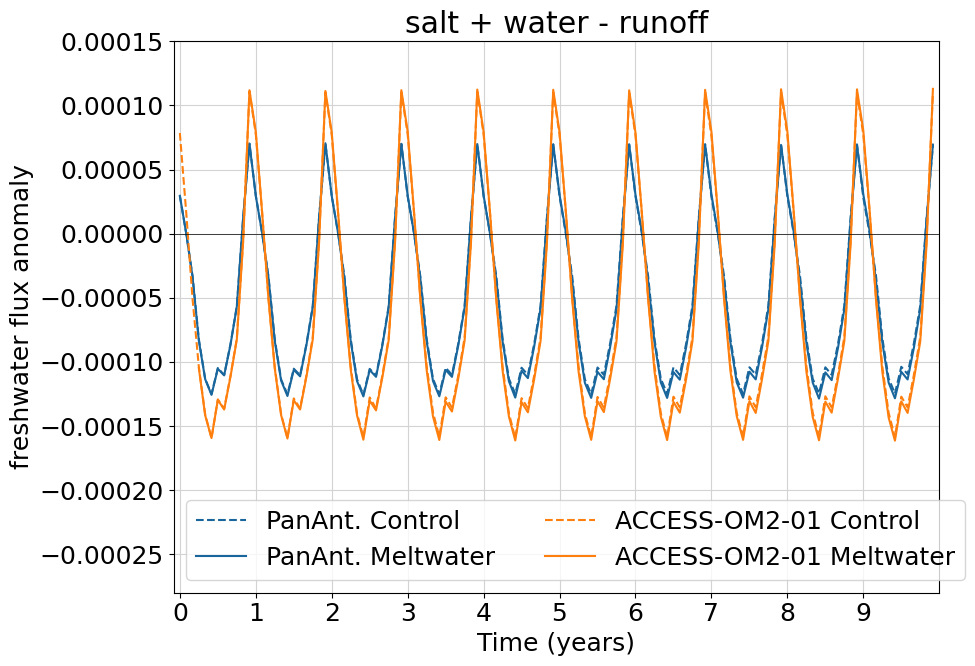

In [6]:
plt.rcParams['font.size'] = 18

plt.figure(figsize=(10, 7))
plt.plot(pan_flux_C_new.index, pan_flux_C_new.values, label='PanAnt. Control', color = colors['pan01_pre'], linestyle = '--')
plt.plot(pan_flux_M_new.index, pan_flux_M_new.values, label = 'PanAnt. Meltwater', color =  colors['pan01_pre'], linestyle = '-')
plt.plot(acc_flux_C_new.index, acc_flux_C_new.values, label='ACCESS-OM2-01 Control',color =  colors['access_pre'], linestyle = '--')
plt.plot(acc_flux_M_new.index, acc_flux_M_new.values, label = 'ACCESS-OM2-01 Meltwater',color =  colors['access_pre'], linestyle = '-')

# Set x-axis ticks to represent years 1 through 10
plt.xticks(ticks=range(1, 121, 12), labels=[str(i) for i in range(0, 10)])

# Labeling and formatting
plt.axhline(0, color='black', linewidth=0.5)
plt.xlabel('Time (years)')
plt.ylabel("freshwater flux anomaly")
plt.title('')
plt.legend(ncols=2)
plt.xlim(0,121)
plt.ylim(-0.00028,0.00015)
plt.grid(True, color='lightgrey')
plt.title('salt + water - runoff')
plt.tight_layout()
plt.show()


In [7]:
# import numpy as np
# import matplotlib.pyplot as plt

# plt.rcParams['font.size'] = 18

# # --- Set numeric indices (months since start) ---
# pan_flux_C_new.index = range(1, len(pan_flux_C_new) + 1)
# pan_flux_M_new.index = range(1, len(pan_flux_M_new) + 1)
# acc_flux_C_new.index = range(1, len(acc_flux_C_new) + 1)
# acc_flux_M_new.index = range(1, len(acc_flux_M_new) + 1)  # will handle offset below

# # --- Function for 5-year monthly climatology with offset support ---
# def five_year_climatology(series, start=60, end=120, offset=0):
#     """
#     Compute 5-year monthly climatology for a series (assumed monthly).
#     offset: integer month offset (positive = shift forward in time)
#     """
#     # apply offset
#     if offset != 0:
#         series = series.shift(offset)

#     # extract 5-year segment
#     sub = series[start:end].dropna()
#     n = (len(sub) // 12) * 12  # trim to full years
#     sub = sub.iloc[:n]
#     reshaped = sub.values.reshape(n // 12, 12)
#     return reshaped.mean(axis=0)

# # --- Compute climatologies ---
# panC_clim = five_year_climatology(pan_flux_C_new)
# panM_clim = five_year_climatology(pan_flux_M_new)
# accC_clim = five_year_climatology(acc_flux_C_new)
# accM_clim = five_year_climatology(acc_flux_M_new, offset=3)  # 4-month lag included here

# # --- Plot ---
# months = np.arange(1, 13)
# month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
#                 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# plt.figure(figsize=(10, 7))
# plt.plot(months, panC_clim, label='PanAnt. Control', color=colors['pan01_pre'], linestyle='--')
# plt.plot(months, panM_clim, label='PanAnt. Meltwater', color=colors['pan01_pre'], linestyle='-')
# plt.plot(months, accC_clim, label='ACCESS-OM2-01 Control', color=colors['access_pre'], linestyle='--')
# plt.plot(months, accM_clim, label='ACCESS-OM2-01 Meltwater', color=colors['access_pre'], linestyle='-')

# plt.axhline(0, color='black', linewidth=0.5)
# plt.xticks(months, month_labels)
# plt.xlabel('Month')
# plt.ylabel('Freshwater flux (kg m$^{-2}$ s$^{-1}$)')
# #plt.title('5-year climatology (salt + water - runoff)')
# plt.legend(ncols=2)
# plt.xlim(1, 12)
# plt.ylim(-0.00028, 0.00015)
# plt.grid(True, color='lightgrey')
# plt.tight_layout()
# plt.show()


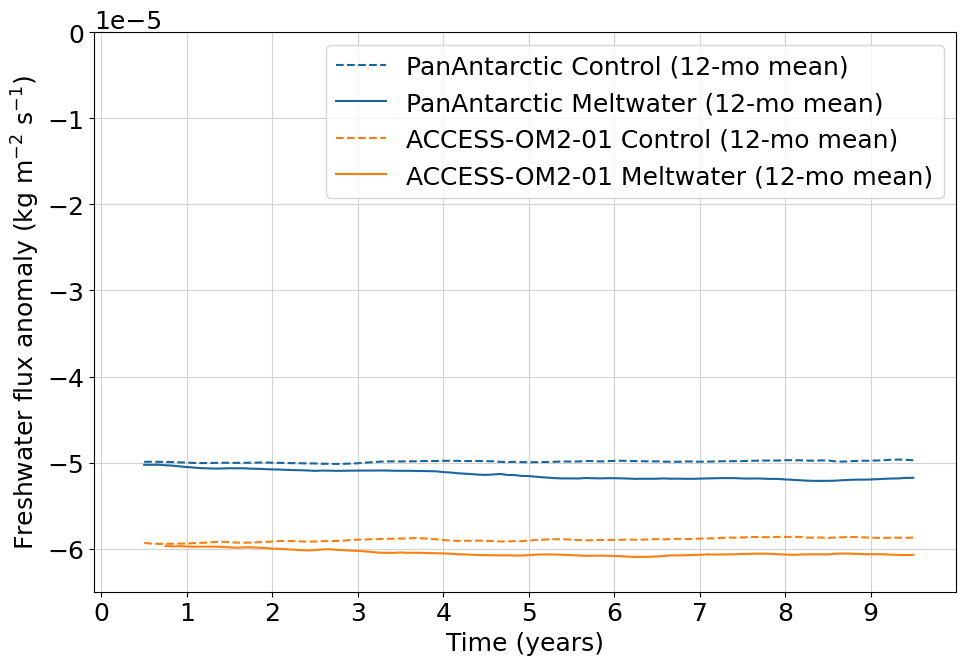

In [8]:
# --- Compute 12-month rolling means ---
pan_flux_C_roll = pan_flux_C_new.rolling(window=12, center=True).mean()
pan_flux_M_roll = pan_flux_M_new.rolling(window=12, center=True).mean()
acc_flux_C_roll = acc_flux_C_new.rolling(window=12, center=True).mean()
acc_flux_M_roll = acc_flux_M_new.rolling(window=12, center=True).mean()

# --- Plot ---
plt.rcParams['font.size'] = 18
plt.figure(figsize=(10, 7))

# PanAntarctic
#plt.plot(pan_flux_C_new.index, pan_flux_C_new.values, color=lighten(colors['pan01_pre'],0.5), linestyle='--')
#plt.plot(pan_flux_M_new.index, pan_flux_M_new.values, color=lighten(colors['pan01_pre'],0.5), linestyle='-')

# ACCESS-OM2-01
#plt.plot(acc_flux_C_new.index, acc_flux_C_new.values, color=lighten(colors['access_pre'],0.5), linestyle='--')
#plt.plot(acc_flux_M_new.index, acc_flux_M_new.values, color=lighten(colors['access_pre'],0.5), linestyle='-')

# PanAntarctic
plt.plot(pan_flux_C_new.index, pan_flux_C_roll.values, label='PanAntarctic Control (12-mo mean)', color=colors['pan01_pre'], linestyle='--')
plt.plot(pan_flux_M_new.index, pan_flux_M_roll.values, label='PanAntarctic Meltwater (12-mo mean)', color=colors['pan01_pre'], linestyle='-')

# ACCESS-OM2-01
plt.plot(acc_flux_C_new.index, acc_flux_C_roll.values, label='ACCESS-OM2-01 Control (12-mo mean)', color=colors['access_pre'], linestyle='--')
plt.plot(acc_flux_M_new.index, acc_flux_M_roll.values, label='ACCESS-OM2-01 Meltwater (12-mo mean)', color=colors['access_pre'], linestyle='-')

# --- Formatting ---
plt.axhline(0, color='black', linewidth=0.5)
plt.xticks(ticks=range(1, 121, 12), labels=[str(i) for i in range(0, 10)])
plt.xlabel('Time (years)')
plt.ylabel('Freshwater flux anomaly (kg m$^{-2}$ s$^{-1}$)')
plt.legend(ncols=1)
plt.xlim(0, 121)
plt.ylim(-0.000065, 0)
plt.grid(True, color='lightgrey')
#plt.title('Salt + water - runoff (12-month rolling mean)')
plt.tight_layout()
plt.show()


# Plotting individual components

In [9]:
lat_slice = slice(-79,-59)

# Importing data
pathsC_1 = np.sort(glob.glob('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/*/*.ocean_month.nc'))[24:]
pathsM_1 = np.sort(glob.glob('/scratch/x77/jn8053/mom6/archive/panant-01-zstar-ssp126-prsc-rest/*/*.ocean_month.nc'))

pathsC_2 = np.sort(glob.glob('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_21mbath/outpu*/ocean/ocean_month.nc'))
pathsM_2 = np.sort(glob.glob('/scratch/x77/jn8053/access-om2/archive/01deg_jra55v13_ryf9091_21mbath_sofia_ssp126_prsc_rest/*/ocean/ocean_month.nc'))

In [10]:
def preprocess_1(ds):
    ds = ds[['wfo','lrunoff']].sel(yh=lat_slice) 
    return ds

cont_pan = xr.open_mfdataset(pathsC_1, preprocess = preprocess_1, chunks = 'auto')
melt_pan = xr.open_mfdataset(pathsM_1, preprocess = preprocess_1, chunks = 'auto')

def preprocess_2(ds):
    ds = ds[['pme_river','runoff','wfimelt','wfiform']].sel(yt_ocean=lat_slice) 
    return ds

cont_acc = xr.open_mfdataset(pathsC_2, preprocess = preprocess_2, chunks = 'auto')
melt_acc = xr.open_mfdataset(pathsM_2, preprocess = preprocess_2, chunks = 'auto')

In [11]:
# Time slice
cont_pan = cont_pan.sel(time=slice('2001-01-01','2010-12-31'))
melt_pan = melt_pan.sel(time=slice('2001-01-01','2010-12-31'))

cont_acc = cont_acc.sel(time=slice('1910-01-01','1919-12-31'))
melt_acc = melt_acc.sel(time=slice('1910-01-01','1919-12-31'))

In [12]:
### Importing files for PanAntarctic ###

#flux_ice_restore_pan_M = xr.open_dataarray('/g/data/g40/kc5856/access_panan_ssp126_SWMT/restoring_checks/salt_flux_melt_asFWF_prescribed_pan01.nc') # instead importing ice FWF separately
#flux_ice_restore_pan_C = xr.open_dataarray('/g/data/g40/kc5856/access_panan_ssp126_SWMT/restoring_checks/salt_flux_con_asFWF_prescribed_pan01.nc')

# Minus sign because I saved these without the negative accidentally
restoring_pan_C = -1 * xr.open_dataarray('/g/data/g40/kc5856/access_panan_ssp126_SWMT/restoring_checks/restoring_con_prescribed_pan01.nc')
restoring_pan_M = -1 * xr.open_dataarray('/g/data/g40/kc5856/access_panan_ssp126_SWMT/restoring_checks/restoring_melt_prescribed_pan01.nc')

#flux_ice_pan_C = flux_ice_restore_pan_C - restoring_pan_C # fixed ice conversion
#flux_ice_pan_M = flux_ice_restore_pan_M - restoring_pan_M
flux_ice_pan_C = xr.open_dataarray('/g/data/g40/kc5856/access_panan_ssp126_SWMT/restoring_checks/icesalt_asFWF_SSS_C_prescribed_pan01.nc')
flux_ice_pan_M = xr.open_dataarray('/g/data/g40/kc5856/access_panan_ssp126_SWMT/restoring_checks/icesalt_asFWF_SSS_M_prescribed_pan01.nc')

flux_water_pan_C = cont_pan['wfo']
flux_water_pan_M = melt_pan['wfo']

flux_runoff_pan_C = cont_pan['lrunoff']
flux_runoff_pan_M = melt_pan['lrunoff']

### Importing files for ACCESS-OM2-01 ###

flux_ice_acc_C = xr.open_dataarray('/g/data/g40/kc5856/access_panan_ssp126_SWMT/restoring_checks/icesalt_asFWF_SSS_C_prescribed_access.nc')
flux_ice_acc_M = xr.open_dataarray('/g/data/g40/kc5856/access_panan_ssp126_SWMT/restoring_checks/icesalt_asFWF_SSS_M_prescribed_access.nc')

# Minus sign because I saved these without the negative accidentally
restoring_acc_C = -1 * xr.open_dataarray('/g/data/g40/kc5856/access_panan_ssp126_SWMT/restoring_checks/restoring_con_prescribed_access.nc')
restoring_acc_M = -1 * xr.open_dataarray('/g/data/g40/kc5856/access_panan_ssp126_SWMT/restoring_checks/restoring_correct_melt_prescribed_access.nc')

flux_pme_river_acc_C = cont_acc['pme_river']
flux_pme_river_acc_M = melt_acc['pme_river']

flux_wfi_ice_acc_C = cont_acc['wfiform'] + cont_acc['wfimelt']
flux_wfi_ice_acc_M = melt_acc['wfiform'] + melt_acc['wfimelt']

flux_water_acc_C = flux_pme_river_acc_C + flux_wfi_ice_acc_C
flux_water_acc_M = flux_pme_river_acc_M + flux_wfi_ice_acc_M

flux_runoff_acc_C = cont_acc['runoff']
flux_runoff_acc_M = melt_acc['runoff']

# Combining to compare to panant
flux_ice_restore_acc_C = restoring_acc_C + flux_ice_acc_C
flux_ice_restore_acc_M = restoring_acc_M + flux_ice_acc_M

In [13]:
# Import area
area_old_1 = xr.open_dataset('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output050/20050501.ocean_static.nc')['areacello']
var_1 = xr.open_dataset('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output050/20050501.ocean_month_z.nc')['so'].isel(z_l=0,time=0)
area_corr_1 = area_old_1*(var_1*0 +1)

area_old_2 = xr.open_dataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_21mbath/output012/ocean/ocean_grid.nc')['area_t']
var_2 = xr.open_dataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_21mbath/output012/ocean/ocean.nc')['salt'].isel(st_ocean=0,time=0).sel(yt_ocean=slice(-79,-39))
area_corr_2 = area_old_2*(var_2*0 +1)

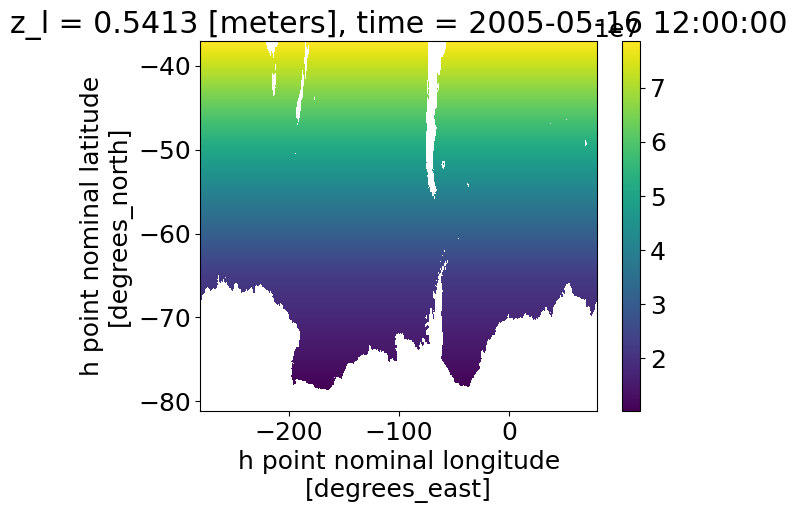

In [14]:
area_corr_1.plot()

In [15]:
# Shelf mask

def shelf_mask_isobath(var, model_dict):

    paths = {
             "mom5": "/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz",
             "mom6_01": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_01deg.nc",
            "mom6_005": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_005deg.nc"
             }

    var = var.cf.sel({'latitude': slice(-90, -59)})

    if paths[model_dict][-3:] == '.nc':
        shelf_mask = xr.open_dataset(paths[model_dict])['contour_masked_above']
    else:
        contour_file = np.load(paths[model_dict])
        shelf_mask = xr.DataArray(contour_file['contour_masked_above'],
                                  coords = var.coords, 
                                  dims = var.dims,
                                  name = 'contour_masked_above')
    
    shelf_mask = xr.where(shelf_mask == 0, 1, 0)
    masked_var = var * shelf_mask
    
    return masked_var, shelf_mask

depth_1 = xr.open_dataset('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output050/20050501.ocean_static.nc')['deptho']
land_mask_1 = (0 * depth_1).fillna(1)
depth_shelf_1, shelf_mask_1 = shelf_mask_isobath(depth_1, 'mom6_01')

depth_2 = xr.open_dataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_21mbath/output012/ocean/ocean_grid.nc')['ht']
land_mask_2 = (0 * depth_2).fillna(1)
depth_shelf_2, shelf_mask_2 = shelf_mask_isobath(depth_2, 'mom5')

In [16]:
# Spatial average
#shelf_ice_restore_pan_C = (area_corr_1 * flux_ice_restore_pan_C.where(shelf_mask_1 == 1)).sum(['xh', 'yh']) / area_corr_1.where(shelf_mask_1 == 1).sum(['xh', 'yh'])
#shelf_ice_restore_pan_M = (area_corr_1 * flux_ice_restore_pan_M.where(shelf_mask_1 == 1)).sum(['xh', 'yh']) / area_corr_1.where(shelf_mask_1 == 1).sum(['xh', 'yh'])

shelf_water_pan_C = (area_corr_1 * flux_water_pan_C.where(shelf_mask_1 == 1)).sum(['xh', 'yh']) / area_corr_1.where(shelf_mask_1 == 1).sum(['xh', 'yh'])
shelf_water_pan_M = (area_corr_1 * flux_water_pan_M.where(shelf_mask_1 == 1)).sum(['xh', 'yh']) / area_corr_1.where(shelf_mask_1 == 1).sum(['xh', 'yh'])

shelf_runoff_pan_C = (area_corr_1 * flux_runoff_pan_C.where(shelf_mask_1 == 1)).sum(['xh', 'yh']) / area_corr_1.where(shelf_mask_1 == 1).sum(['xh', 'yh'])
shelf_runoff_pan_M = (area_corr_1 * flux_runoff_pan_M.where(shelf_mask_1 == 1)).sum(['xh', 'yh']) / area_corr_1.where(shelf_mask_1 == 1).sum(['xh', 'yh'])

shelf_restore_pan_C = (area_corr_1 * restoring_pan_C.where(shelf_mask_1 == 1)).sum(['xh', 'yh']) / area_corr_1.where(shelf_mask_1 == 1).sum(['xh', 'yh'])
shelf_restore_pan_M = (area_corr_1 * restoring_pan_M.where(shelf_mask_1 == 1)).sum(['xh', 'yh']) / area_corr_1.where(shelf_mask_1 == 1).sum(['xh', 'yh'])

shelf_ice_pan_C = (area_corr_1 * flux_ice_pan_C.where(shelf_mask_1 == 1)).sum(['xh', 'yh']) / area_corr_1.where(shelf_mask_1 == 1).sum(['xh', 'yh'])
shelf_ice_pan_M = (area_corr_1 * flux_ice_pan_M.where(shelf_mask_1 == 1)).sum(['xh', 'yh']) / area_corr_1.where(shelf_mask_1 == 1).sum(['xh', 'yh'])

#shelf_ice_restore_acc_C = (area_corr_2 * flux_ice_restore_acc_C.where(shelf_mask_2 == 1)).sum(['xt_ocean', 'yt_ocean']) / area_corr_2.where(shelf_mask_2 == 1).sum(['xt_ocean', 'yt_ocean'])
#shelf_ice_restore_acc_M = (area_corr_2 * flux_ice_restore_acc_M.where(shelf_mask_2 == 1)).sum(['xt_ocean', 'yt_ocean']) / area_corr_2.where(shelf_mask_2 == 1).sum(['xt_ocean', 'yt_ocean'])

shelf_water_acc_C = (area_corr_2 * flux_water_acc_C.where(shelf_mask_2 == 1)).sum(['xt_ocean', 'yt_ocean']) / area_corr_2.where(shelf_mask_2 == 1).sum(['xt_ocean', 'yt_ocean'])
shelf_water_acc_M = (area_corr_2 * flux_water_acc_M.where(shelf_mask_2 == 1)).sum(['xt_ocean', 'yt_ocean']) / area_corr_2.where(shelf_mask_2 == 1).sum(['xt_ocean', 'yt_ocean'])

shelf_runoff_acc_C = (area_corr_2 * flux_runoff_acc_C.where(shelf_mask_2 == 1)).sum(['xt_ocean', 'yt_ocean']) / area_corr_2.where(shelf_mask_2 == 1).sum(['xt_ocean', 'yt_ocean'])
shelf_runoff_acc_M = (area_corr_2 * flux_runoff_acc_M.where(shelf_mask_2 == 1)).sum(['xt_ocean', 'yt_ocean']) / area_corr_2.where(shelf_mask_2 == 1).sum(['xt_ocean', 'yt_ocean'])

shelf_restore_acc_C = (area_corr_2 * restoring_acc_C.where(shelf_mask_2 == 1)).sum(['xt_ocean', 'yt_ocean']) / area_corr_2.where(shelf_mask_2 == 1).sum(['xt_ocean', 'yt_ocean'])
shelf_restore_acc_M = (area_corr_2 * restoring_acc_M.where(shelf_mask_2 == 1)).sum(['xt_ocean', 'yt_ocean']) / area_corr_2.where(shelf_mask_2 == 1).sum(['xt_ocean', 'yt_ocean'])

shelf_ice_acc_C = (area_corr_2 * flux_ice_acc_C).where(shelf_mask_2 == 1).sum(['xt_ocean', 'yt_ocean']) / area_corr_2.where(shelf_mask_2 == 1).sum(['xt_ocean', 'yt_ocean'])
shelf_ice_acc_M = (area_corr_2 * flux_ice_acc_M).where(shelf_mask_2 == 1).sum(['xt_ocean', 'yt_ocean']) / area_corr_2.where(shelf_mask_2 == 1).sum(['xt_ocean', 'yt_ocean'])

# Individual water flux terms for ACCESS
shelf_pme_river_acc_C = (area_corr_2 * flux_pme_river_acc_C.where(shelf_mask_2 == 1)).sum(['xt_ocean', 'yt_ocean']) / area_corr_2.where(shelf_mask_2 == 1).sum(['xt_ocean', 'yt_ocean'])
shelf_pme_river_acc_M = (area_corr_2 * flux_pme_river_acc_M.where(shelf_mask_2 == 1)).sum(['xt_ocean', 'yt_ocean']) / area_corr_2.where(shelf_mask_2 == 1).sum(['xt_ocean', 'yt_ocean'])

shelf_wfi_ice_acc_C = (area_corr_2 * flux_wfi_ice_acc_C.where(shelf_mask_2 == 1)).sum(['xt_ocean', 'yt_ocean']) / area_corr_2.where(shelf_mask_2 == 1).sum(['xt_ocean', 'yt_ocean'])
shelf_wfi_ice_acc_M = (area_corr_2 * flux_wfi_ice_acc_M.where(shelf_mask_2 == 1)).sum(['xt_ocean', 'yt_ocean']) / area_corr_2.where(shelf_mask_2 == 1).sum(['xt_ocean', 'yt_ocean'])

In [17]:
# shelf_ice_restore_pan_C = shelf_ice_restore_pan_C.load()
# shelf_ice_restore_pan_M = shelf_ice_restore_pan_M.load()
# shelf_ice_restore_acc_C = shelf_ice_restore_acc_C.load()
# shelf_ice_restore_acc_M = shelf_ice_restore_acc_M.load()

shelf_water_pan_C = shelf_water_pan_C.load()
shelf_water_pan_M = shelf_water_pan_M.load()
shelf_runoff_pan_C = shelf_runoff_pan_C.load()
shelf_runoff_pan_M = shelf_runoff_pan_M.load()
shelf_water_acc_C = shelf_water_acc_C.load()
shelf_water_acc_M = shelf_water_acc_M.load()
shelf_runoff_acc_C = shelf_runoff_acc_C.load()
shelf_runoff_acc_M = shelf_runoff_acc_M.load()

In [18]:
shelf_restore_pan_C = shelf_restore_pan_C.load()
shelf_restore_pan_M = shelf_restore_pan_M.load()
shelf_ice_pan_C = shelf_ice_pan_C.load()
shelf_ice_pan_M = shelf_ice_pan_M.load()
shelf_ice_acc_C = shelf_ice_acc_C.load()
shelf_ice_acc_M = shelf_ice_acc_M.load()
shelf_restore_acc_C = shelf_restore_acc_C.load()
shelf_restore_acc_M = shelf_restore_acc_M.load()

In [19]:
shelf_wfi_ice_acc_C = shelf_wfi_ice_acc_C.load()
shelf_wfi_ice_acc_M = shelf_wfi_ice_acc_M.load()

In [20]:
shelf_pme_river_acc_C = shelf_pme_river_acc_C.load()
shelf_pme_river_acc_M = shelf_pme_river_acc_M.load()

In [21]:
# shelf_ice_restore_pan_C_new = shelf_ice_restore_pan_C.to_series()['2001-01-01':'2010-12-16']
# shelf_ice_restore_pan_M_new = shelf_ice_restore_pan_M.to_series()['2001-01-01':'2010-12-16']
# shelf_ice_restore_acc_C_new = shelf_ice_restore_acc_C.to_series()['1910-01-01':'1919-12-16']
# shelf_ice_restore_acc_M_new = shelf_ice_restore_acc_M.to_series()['1910-01-01':'1919-12-16']

shelf_water_pan_C_new = shelf_water_pan_C.to_series()['2001-01-01':'2010-12-16']
shelf_water_pan_M_new = shelf_water_pan_M.to_series()['2001-01-01':'2010-12-16']
shelf_runoff_pan_C_new = shelf_runoff_pan_C.to_series()['2001-01-01':'2010-12-16']
shelf_runoff_pan_M_new = shelf_runoff_pan_M.to_series()['2001-01-01':'2010-12-16']
shelf_restore_pan_C_new = shelf_restore_pan_C.to_series()['2001-01-01':'2010-12-16']
shelf_restore_pan_M_new = shelf_restore_pan_M.to_series()['2001-01-01':'2010-12-16']
shelf_ice_pan_C_new = shelf_ice_pan_C.to_series()['2001-01-01':'2010-12-16']
shelf_ice_pan_M_new = shelf_ice_pan_M.to_series()['2001-01-01':'2010-12-16']

shelf_water_acc_C_new = shelf_water_acc_C.to_series()['1910-01-01':'1919-12-16']
shelf_water_acc_M_new = shelf_water_acc_M.to_series()['1910-01-01':'1919-12-16']
shelf_runoff_acc_C_new = shelf_runoff_acc_C.to_series()['1910-01-01':'1919-12-16']
shelf_runoff_acc_M_new = shelf_runoff_acc_M.to_series()['1910-01-01':'1919-12-16']
shelf_ice_acc_C_new = shelf_ice_acc_C.to_series()['1910-01-01':'1919-12-16']
shelf_ice_acc_M_new = shelf_ice_acc_M.to_series()['1910-01-01':'1919-12-16']
shelf_restore_acc_C_new = shelf_restore_acc_C.to_series()['1910-01-01':'1919-12-16']
shelf_restore_acc_M_new = shelf_restore_acc_M.to_series()['1910-01-01':'1919-12-16']

shelf_wfi_ice_acc_C_new = shelf_wfi_ice_acc_C.to_series()['1910-01-01':'1919-12-16']
shelf_wfi_ice_acc_M_new = shelf_wfi_ice_acc_M.to_series()['1910-01-01':'1919-12-16']
shelf_pme_river_acc_C_new = shelf_pme_river_acc_C.to_series()['1910-01-01':'1919-12-16']
shelf_pme_river_acc_M_new = shelf_pme_river_acc_M.to_series()['1910-01-01':'1919-12-16']

In [22]:
# because it turns out pme_river does include the ice anyway, redefining:
shelf_water_acc_C_new = shelf_pme_river_acc_C_new
shelf_water_acc_M_new = shelf_pme_river_acc_M_new

In [23]:
# shelf_ice_restore_pan_C_new.index = range(1, len(shelf_ice_restore_pan_C_new)+1)
# shelf_ice_restore_pan_M_new.index = range(1, len(shelf_ice_restore_pan_M_new)+1)
# shelf_ice_restore_acc_C_new.index = range(1, len(shelf_ice_restore_acc_C_new)+1)
# shelf_ice_restore_acc_M_new.index = range(4, len(shelf_ice_restore_acc_M_new)+4)

shelf_water_pan_C_new.index = range(1, len(shelf_water_pan_C_new)+1)
shelf_water_pan_M_new.index = range(1, len(shelf_water_pan_M_new)+1)
shelf_runoff_pan_C_new.index = range(1, len(shelf_runoff_pan_M_new)+1)
shelf_runoff_pan_M_new.index = range(1, len(pan_flux_C_new)+1)
shelf_restore_pan_C_new.index = range(1, len(shelf_restore_pan_C_new)+1)
shelf_restore_pan_M_new.index = range(1, len(shelf_restore_pan_M_new)+1)
shelf_ice_pan_C_new.index = range(1, len(shelf_ice_pan_C_new)+1)
shelf_ice_pan_M_new.index = range(1, len(shelf_ice_pan_M_new)+1)

shelf_water_acc_C_new.index = range(1, len(shelf_water_acc_C_new)+1)
shelf_water_acc_M_new.index= range(1, len(shelf_water_acc_M_new)+1)
shelf_runoff_acc_C_new.index = range(1, len(shelf_runoff_acc_C_new)+1)
shelf_runoff_acc_M_new.index = range(1, len(shelf_runoff_acc_M_new)+1)
shelf_ice_acc_C_new.index = range(1, len(shelf_ice_acc_C_new)+1)
shelf_ice_acc_M_new.index = range(1, len(shelf_ice_acc_M_new)+1)
shelf_restore_acc_C_new.index = range(1, len(shelf_restore_acc_C_new)+1)
shelf_restore_acc_M_new.index = range(4, len(shelf_restore_acc_M_new)+4)

shelf_wfi_ice_acc_C_new.index = range(1, len(shelf_wfi_ice_acc_C_new)+1)
shelf_wfi_ice_acc_M_new.index = range(1, len(shelf_wfi_ice_acc_M_new)+1)
shelf_pme_river_acc_C_new.index = range(1, len(shelf_pme_river_acc_C_new)+1)
shelf_pme_river_acc_M_new.index = range(1, len(shelf_pme_river_acc_M_new)+1)

In [24]:
# Colours for plotting
colors = {'pan01_res': '#0000a2',
          'pan005_res': '#E84141',
          'pan01_pre' : '#18669C',
          'access_pre': 'tab:orange'}

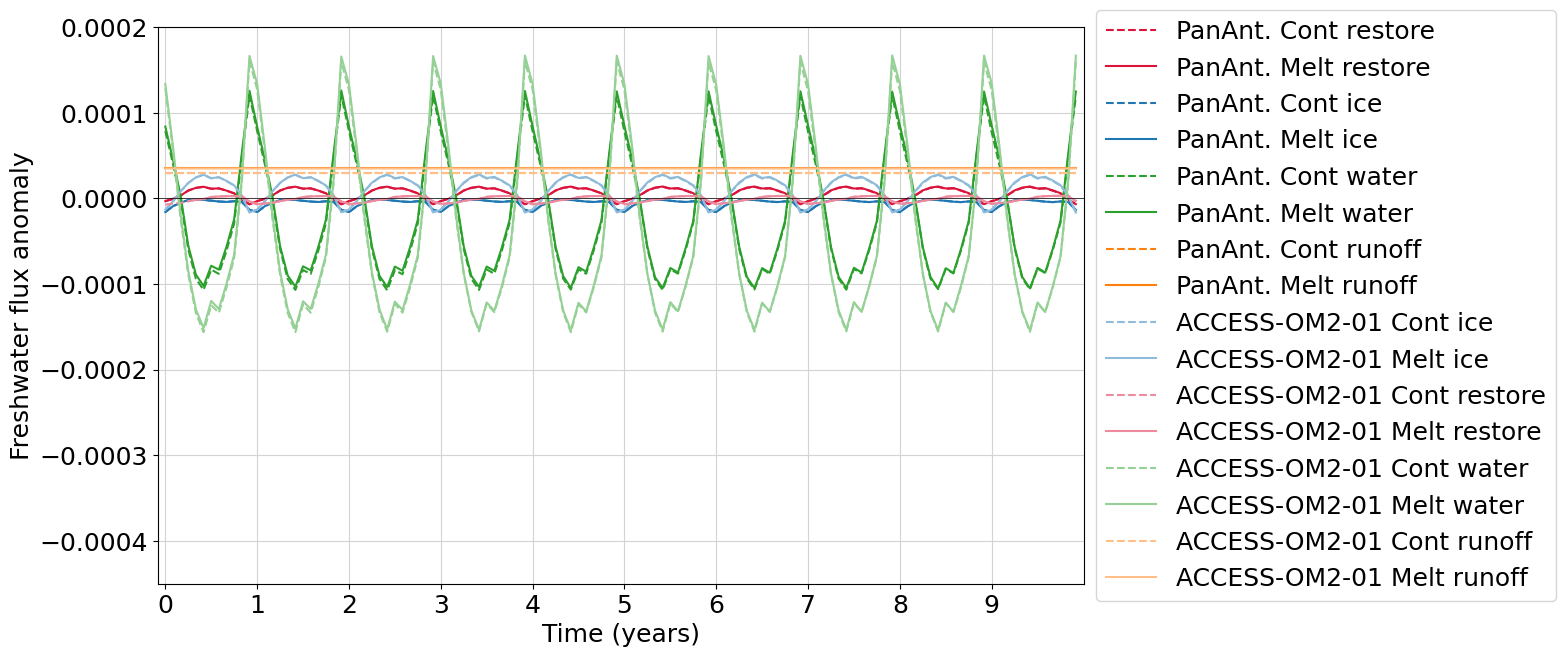

In [25]:
plt.rcParams['font.size'] = 18

plt.figure(figsize=(16, 7))

# Define distinguishable colors per forcing type
# (tuned for contrast and accessibility)
forcing_colors = {
    'ice': '#1f77b4',  # blue
    'restore':'crimson',
    'water': '#2ca02c',        # green
    'runoff': '#ff7f0e'        # orange
}

# PanAntarctic (dashed, solid, etc.)
plt.plot(shelf_ice_pan_C_new.index, shelf_ice_pan_C_new.values,
         label='PanAnt. Cont restore', color=forcing_colors['restore'], linestyle='--')
plt.plot(shelf_ice_pan_M_new.index, shelf_ice_pan_M_new.values,
         label='PanAnt. Melt restore', color=forcing_colors['restore'], linestyle='-')

plt.plot(shelf_restore_pan_C_new.index, shelf_restore_pan_C_new.values,
         label='PanAnt. Cont ice', color=forcing_colors['ice'], linestyle='--')
plt.plot(shelf_restore_pan_M_new.index, shelf_restore_pan_M_new.values,
         label='PanAnt. Melt ice', color=forcing_colors['ice'], linestyle='-')

plt.plot(shelf_water_pan_C_new.index, shelf_water_pan_C_new.values,
         label='PanAnt. Cont water', color=forcing_colors['water'], linestyle='--')
plt.plot(shelf_water_pan_M_new.index, shelf_water_pan_M_new.values,
         label='PanAnt. Melt water', color=forcing_colors['water'], linestyle='-')

plt.plot(shelf_runoff_pan_C_new.index, shelf_runoff_pan_C_new.values,
         label='PanAnt. Cont runoff', color=forcing_colors['runoff'], linestyle='--')
plt.plot(shelf_runoff_pan_M_new.index, shelf_runoff_pan_M_new.values,
         label='PanAnt. Melt runoff', color=forcing_colors['runoff'], linestyle='-')

# ACCESS-OM2-01 (use slightly lighter/darker variants for distinction)
from matplotlib.colors import to_rgba
def lighten(color, amount=0.4):
    c = np.array(to_rgba(color))
    return tuple(c[:3] + (1 - c[:3]) * amount)

plt.plot(shelf_ice_acc_C_new.index, shelf_ice_acc_C_new.values,
         label='ACCESS-OM2-01 Cont ice', color=lighten(forcing_colors['ice'], 0.5), linestyle='--')
plt.plot(shelf_ice_acc_M_new.index, shelf_ice_acc_M_new.values,
         label='ACCESS-OM2-01 Melt ice', color=lighten(forcing_colors['ice'], 0.5), linestyle='-')

plt.plot(shelf_restore_acc_C_new.index, shelf_restore_acc_C_new.values,
         label='ACCESS-OM2-01 Cont restore', color=lighten(forcing_colors['restore'], 0.5), linestyle='--')
plt.plot(shelf_restore_acc_M_new.index, shelf_restore_acc_M_new.values,
         label='ACCESS-OM2-01 Melt restore', color=lighten(forcing_colors['restore'], 0.5), linestyle='-')

plt.plot(shelf_water_acc_C_new.index, shelf_water_acc_C_new.values,
         label='ACCESS-OM2-01 Cont water', color=lighten(forcing_colors['water'], 0.5), linestyle='--')
plt.plot(shelf_water_acc_M_new.index, shelf_water_acc_M_new.values,
         label='ACCESS-OM2-01 Melt water', color=lighten(forcing_colors['water'], 0.5), linestyle='-')

plt.plot(shelf_runoff_acc_C_new.index, shelf_runoff_acc_C_new.values,
         label='ACCESS-OM2-01 Cont runoff', color=lighten(forcing_colors['runoff'], 0.5), linestyle='--')
plt.plot(shelf_runoff_acc_M_new.index, shelf_runoff_acc_M_new.values,
         label='ACCESS-OM2-01 Melt runoff', color=lighten(forcing_colors['runoff'], 0.5), linestyle='-')

# Axis formatting
plt.xticks(ticks=range(1, 121, 12), labels=[str(i) for i in range(0, 10)])
plt.axhline(0, color='black', linewidth=0.5)
plt.xlabel('Time (years)')
plt.ylabel('Freshwater flux anomaly')
plt.legend(ncols=1, loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlim(0, 121)
plt.ylim(-0.00045, 0.0002)
plt.grid(True, color='lightgrey')
plt.tight_layout()
plt.show()


In [26]:
# --- Define colors per forcing type ---
forcing_colors = {
    'ice': '#1f77b4',  # blue
    'restore':'crimson',
    'water': '#2ca02c',        # green
    'runoff': '#ff7f0e'        # orange
}

# Helper to lighten/darken a color (for second model)
def lighten(color, amount=0.4):
    c = np.array(to_rgba(color))
    return tuple(c[:3] + (1 - c[:3]) * amount)

# --- Compute anomalies (Melt - Control) ---
#an_pan_ice_rest   = shelf_ice_restore_pan_M_new.values - shelf_ice_restore_pan_C_new.values
an_pan_water = shelf_water_pan_M_new.values       - shelf_water_pan_C_new.values
an_pan_real_water = (shelf_water_pan_M_new-shelf_runoff_pan_M_new).values - (shelf_water_pan_C_new-shelf_runoff_pan_C_new).values
an_pan_run   = shelf_runoff_pan_M_new.values      - shelf_runoff_pan_C_new.values
an_pan_ice   = shelf_ice_pan_M_new.values         - shelf_ice_pan_C_new.values
an_pan_rest  = shelf_restore_pan_M_new.values     - shelf_restore_pan_C_new.values

#an_acc_ice_rest   = shelf_ice_restore_acc_M_new.values - shelf_ice_restore_acc_C_new.values[3:]
an_acc_real_water = (shelf_water_acc_M_new-shelf_runoff_acc_M_new).values - (shelf_water_acc_C_new-shelf_runoff_acc_C_new).values
an_acc_water = shelf_water_acc_M_new.values       - shelf_water_acc_C_new.values
an_acc_run   = shelf_runoff_acc_M_new.values      - shelf_runoff_acc_C_new.values
an_acc_ice   = shelf_ice_acc_M_new.values         - shelf_ice_acc_C_new.values
an_acc_rest  = shelf_restore_acc_M_new.values     - shelf_restore_acc_C_new.values[3:]
an_acc_pme_river = shelf_pme_river_acc_M_new.values     - shelf_pme_river_acc_C_new.values

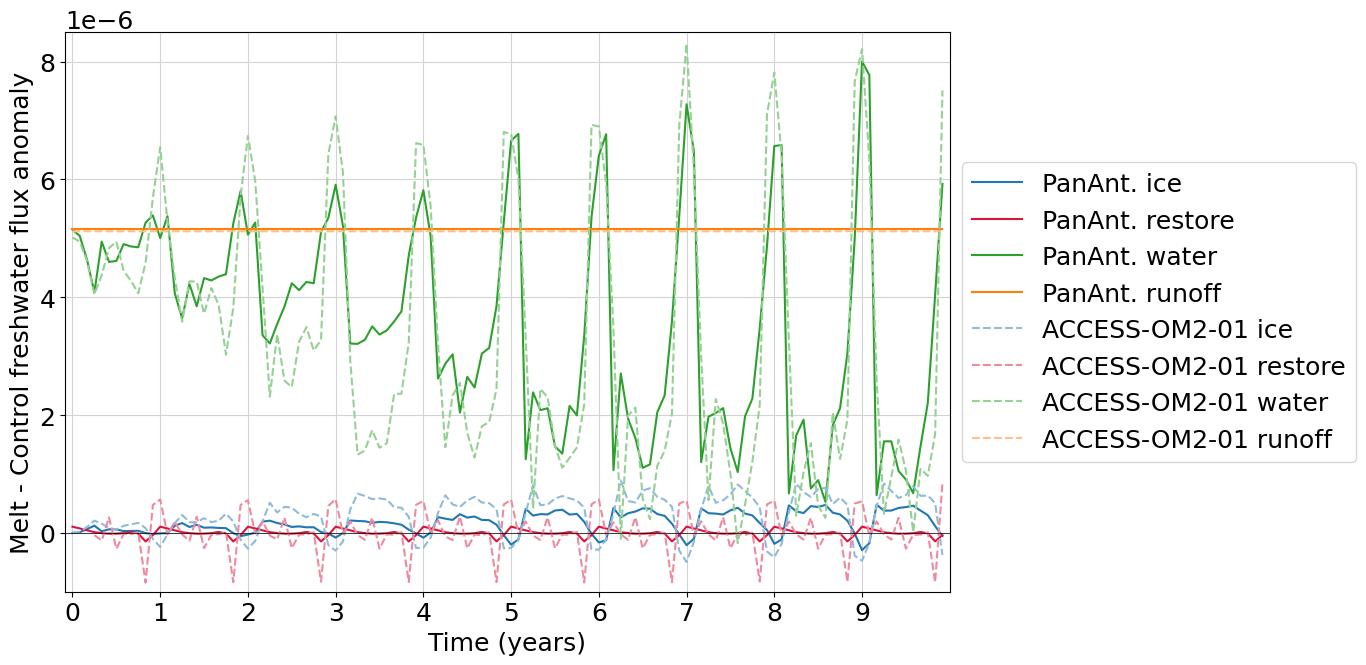

In [27]:
from matplotlib.colors import to_rgba

plt.rcParams['font.size'] = 18
plt.figure(figsize=(14, 7))



# --- Plot PanAntarctic anomalies ---
plt.plot(shelf_ice_pan_M_new.index, an_pan_ice,
         label='PanAnt. ice', color=forcing_colors['ice'], linestyle='-')
plt.plot(shelf_restore_pan_M_new.index, an_pan_rest,
         label='PanAnt. restore', color=forcing_colors['restore'], linestyle='-')
plt.plot(shelf_water_pan_M_new.index, an_pan_water,
         label='PanAnt. water', color=forcing_colors['water'], linestyle='-')
plt.plot(shelf_runoff_pan_M_new.index, an_pan_run,
         label='PanAnt. runoff', color=forcing_colors['runoff'], linestyle='-')

# --- Plot ACCESS-OM2-01 anomalies (lighter tint) ---
plt.plot(shelf_ice_acc_M_new.index, an_acc_ice,
         label='ACCESS-OM2-01 ice', color=lighten(forcing_colors['ice'], 0.5), linestyle='--')
plt.plot(shelf_restore_acc_M_new.index, an_acc_rest,
         label='ACCESS-OM2-01 restore', color=lighten(forcing_colors['restore'], 0.5), linestyle='--')
plt.plot(shelf_water_acc_M_new.index, an_acc_water,
         label='ACCESS-OM2-01 water', color=lighten(forcing_colors['water'], 0.5), linestyle='--')
plt.plot(shelf_runoff_acc_M_new.index, an_acc_run,
         label='ACCESS-OM2-01 runoff', color=lighten(forcing_colors['runoff'], 0.5), linestyle='--')

# --- Axis formatting ---
plt.axhline(0, color='black', linewidth=0.5)
plt.xticks(ticks=range(1, 121, 12), labels=[str(i) for i in range(0, 10)])
plt.xlabel('Time (years)')
plt.ylabel('Melt - Control freshwater flux anomaly')
plt.legend(ncols=1, loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlim(0, 121)
plt.ylim(-0.000001, 0.0000085)
plt.grid(True, color='lightgrey')
plt.tight_layout()
plt.show()


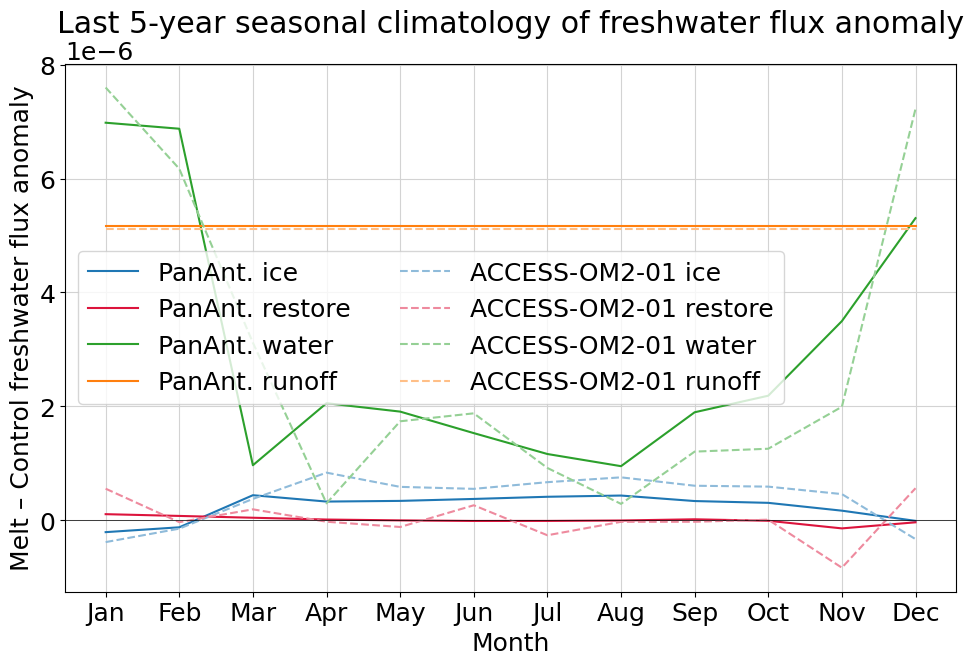

In [28]:
# --- Extract final 5 years (60 months) ---
def last5_clim(anom):
    last60 = anom[-60:]
    # Reshape to (5 years, 12 months)
    reshaped = last60.reshape(5, 12)
    return np.nanmean(reshaped, axis=0)

# --- Compute 12-month climatologies ---
clim_pan_ice   = last5_clim(an_pan_ice)
clim_pan_rest   = last5_clim(an_pan_rest)
clim_pan_water = last5_clim(an_pan_water)
clim_pan_run   = last5_clim(an_pan_run)

clim_acc_ice   = last5_clim(an_acc_ice)
clim_acc_rest   = last5_clim(an_acc_rest)
clim_acc_water = last5_clim(an_acc_water)
clim_acc_run   = last5_clim(an_acc_run)

# --- Plot seasonal climatology ---
months = np.arange(1, 13)

plt.figure(figsize=(10,7))

# PanAntarctic
plt.plot(months, clim_pan_ice, color=forcing_colors['ice'], label='PanAnt. ice', linestyle='-')
plt.plot(months, clim_pan_rest, color=forcing_colors['restore'], label='PanAnt. restore', linestyle='-')
plt.plot(months, clim_pan_water, color=forcing_colors['water'], label='PanAnt. water', linestyle='-')
plt.plot(months, clim_pan_run, color=forcing_colors['runoff'], label='PanAnt. runoff', linestyle='-')

# ACCESS-OM2-01 (lighter tint)
plt.plot(months, clim_acc_ice, color=lighten(forcing_colors['ice'], 0.5), label='ACCESS-OM2-01 ice', linestyle='--')
plt.plot(months, clim_acc_rest, color=lighten(forcing_colors['restore'], 0.5), label='ACCESS-OM2-01 restore', linestyle='--')
plt.plot(months, clim_acc_water, color=lighten(forcing_colors['water'], 0.5), label='ACCESS-OM2-01 water', linestyle='--')
plt.plot(months, clim_acc_run, color=lighten(forcing_colors['runoff'], 0.5), label='ACCESS-OM2-01 runoff', linestyle='--')

# --- Formatting ---
plt.axhline(0, color='black', linewidth=0.5)
plt.xticks(months, ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.xlabel('Month')
plt.ylabel('Melt – Control freshwater flux anomaly')
plt.title('Last 5-year seasonal climatology of freshwater flux anomaly')
plt.legend(ncols=2)
plt.grid(True, color='lightgrey')
plt.tight_layout()
plt.show()

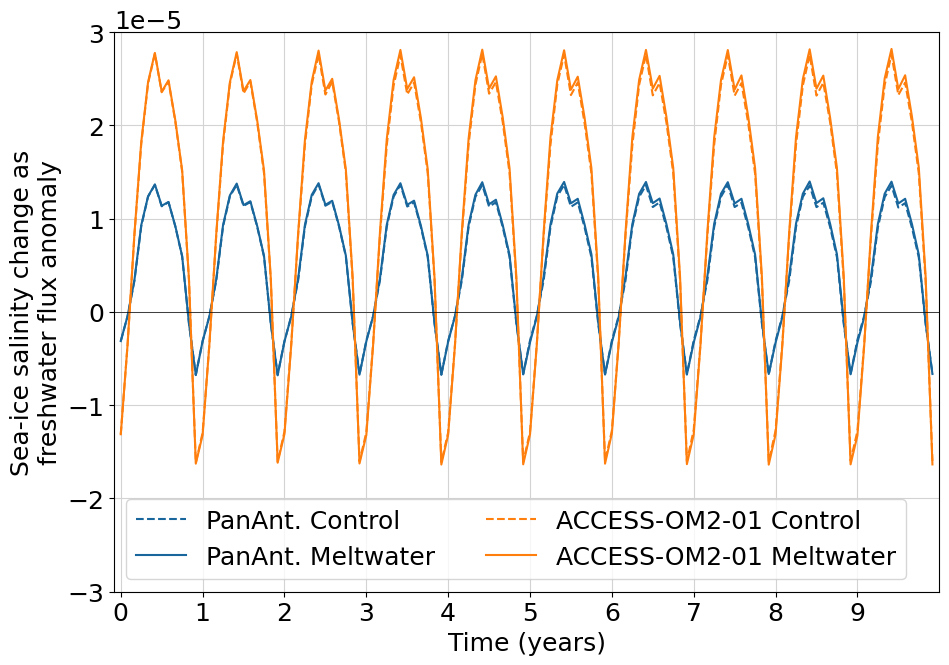

In [29]:
plt.rcParams['font.size'] = 18

plt.figure(figsize=(10, 7))

# Define distinguishable colors per forcing type
# (tuned for contrast and accessibility)
forcing_colors = {
    'ice': '#1f77b4',  # blue
    'restore':'crimson',
    'water': '#2ca02c',        # green
    'runoff': '#ff7f0e'        # orange
}

# PanAntarctic (dashed, solid, etc.)

plt.plot(shelf_ice_pan_C_new.index, shelf_ice_pan_C_new.values,
         label='PanAnt. Control', color=colors['pan01_pre'], linestyle='--')
plt.plot(shelf_ice_pan_M_new.index, shelf_ice_pan_M_new.values,
         label='PanAnt. Meltwater', color=colors['pan01_pre'], linestyle='-')

# ACCESS-OM2-01 (use slightly lighter/darker variants for distinction)
from matplotlib.colors import to_rgba
def lighten(color, amount=0.4):
    c = np.array(to_rgba(color))
    return tuple(c[:3] + (1 - c[:3]) * amount)

plt.plot(shelf_ice_acc_C_new.index, shelf_ice_acc_C_new.values,
         label='ACCESS-OM2-01 Control', color=colors['access_pre'], linestyle='--')
plt.plot(shelf_ice_acc_M_new.index, shelf_ice_acc_M_new.values,
         label='ACCESS-OM2-01 Meltwater', color=colors['access_pre'], linestyle='-')

# Axis formatting
plt.xticks(ticks=range(1, 121, 12), labels=[str(i) for i in range(0, 10)])
plt.axhline(0, color='black', linewidth=0.5)
plt.xlabel('Time (years)')
plt.ylabel('Sea-ice salinity change as\nfreshwater flux anomaly')
plt.legend(ncols=2)
plt.xlim(0, 121)
plt.ylim(-0.00003, 0.00003)
plt.grid(True, color='lightgrey')
plt.tight_layout()
plt.show()


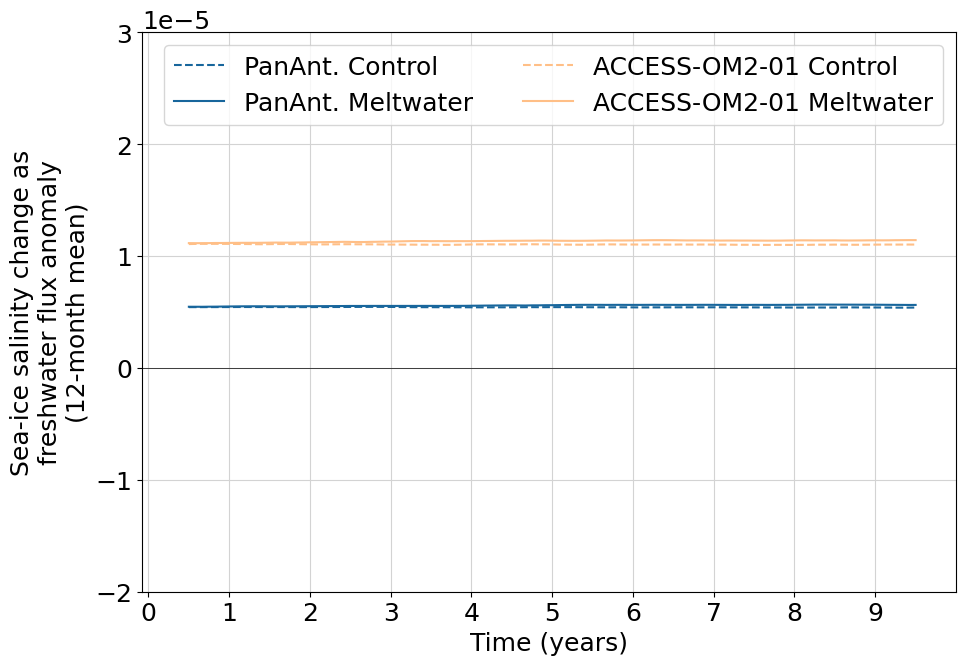

In [30]:
plt.rcParams['font.size'] = 18

plt.figure(figsize=(10, 7))

# Define distinguishable colors per forcing type
forcing_colors = {
    'ice': '#1f77b4',      # blue
    'restore':'crimson',
    'water': '#2ca02c',    # green
    'runoff': '#ff7f0e'    # orange
}

# Function to lighten color
def lighten(color, amount=0.4):
    c = np.array(to_rgba(color))
    return tuple(c[:3] + (1 - c[:3]) * amount)

# Compute 12-month rolling means
shelf_ice_pan_C_rm = shelf_ice_pan_C_new.rolling(window=12, center=True).mean()
shelf_ice_pan_M_rm = shelf_ice_pan_M_new.rolling(window=12, center=True).mean()
shelf_ice_acc_C_rm = shelf_ice_acc_C_new.rolling(window=12, center=True).mean()
shelf_ice_acc_M_rm = shelf_ice_acc_M_new.rolling(window=12, center=True).mean()

# Plot PanAntarctic
plt.plot(shelf_ice_pan_C_rm.index, shelf_ice_pan_C_rm.values,
         label='PanAnt. Control', color=colors['pan01_pre'], linestyle='--')
plt.plot(shelf_ice_pan_M_rm.index, shelf_ice_pan_M_rm.values,
         label='PanAnt. Meltwater', color=colors['pan01_pre'], linestyle='-')

# Plot ACCESS-OM2-01
plt.plot(shelf_ice_acc_C_rm.index, shelf_ice_acc_C_rm.values,
         label='ACCESS-OM2-01 Control', color=lighten(colors['access_pre'], 0.5), linestyle='--')
plt.plot(shelf_ice_acc_M_rm.index, shelf_ice_acc_M_rm.values,
         label='ACCESS-OM2-01 Meltwater', color=lighten(colors['access_pre'], 0.5), linestyle='-')

# Axis formatting
plt.xticks(ticks=range(1, 121, 12), labels=[str(i) for i in range(0, 10)])
plt.axhline(0, color='black', linewidth=0.5)
plt.xlabel('Time (years)')
plt.ylabel('Sea-ice salinity change as\nfreshwater flux anomaly\n(12-month mean)')
plt.legend(ncols=2)
plt.xlim(0, 121)
plt.ylim(-0.00002, 0.00003)
plt.grid(True, color='lightgrey')
plt.tight_layout()
plt.show()


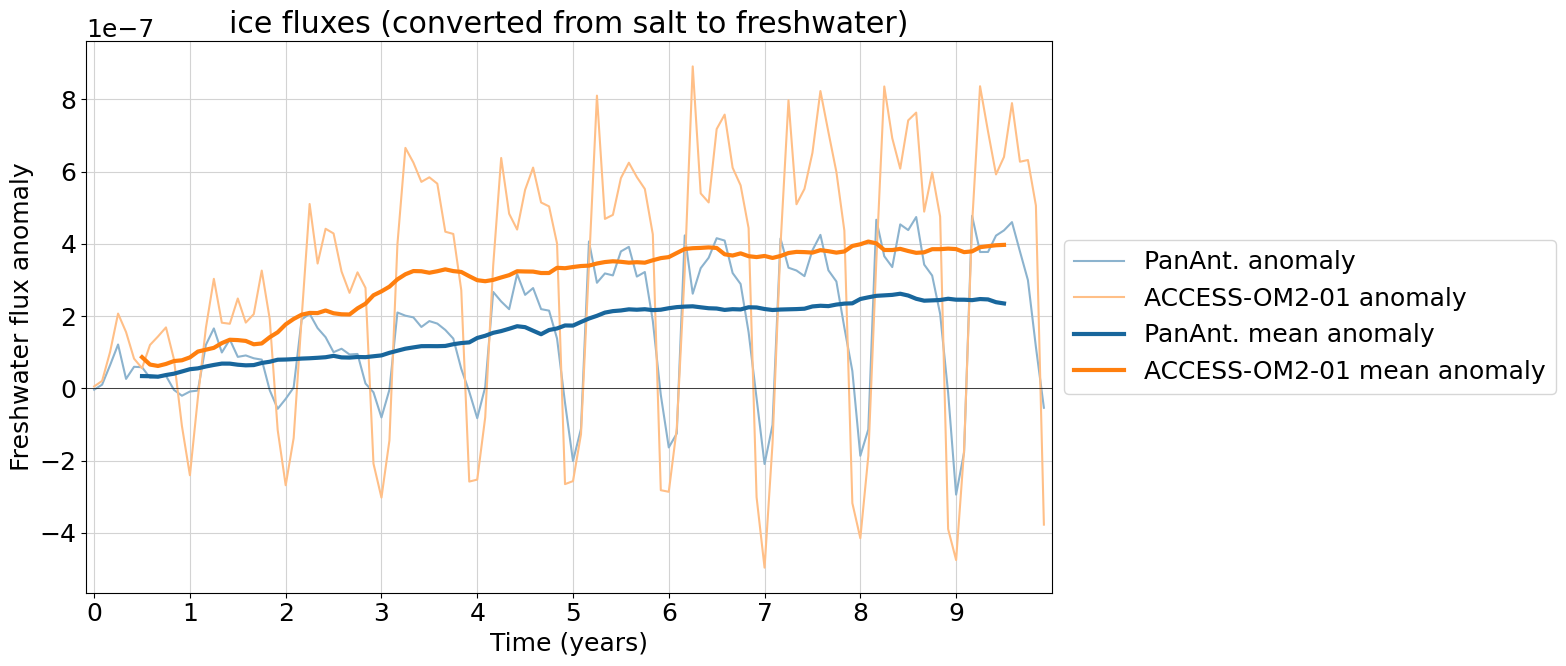

In [31]:
plt.rcParams['font.size'] = 18

plt.figure(figsize=(16, 7))

# Function to lighten color
def lighten(color, amount=0.4):
    c = np.array(to_rgba(color))
    return tuple(c[:3] + (1 - c[:3]) * amount)

# Compute 12-month rolling means
shelf_ice_pan_C_rm = shelf_ice_pan_C_new.rolling(window=12, center=True).mean()
shelf_ice_pan_M_rm = shelf_ice_pan_M_new.rolling(window=12, center=True).mean()
shelf_ice_acc_C_rm = shelf_ice_acc_C_new.rolling(window=12, center=True).mean()
shelf_ice_acc_M_rm = shelf_ice_acc_M_new.rolling(window=12, center=True).mean()

# Plot anomalies
plt.plot((shelf_ice_pan_M_new - shelf_ice_pan_C_new).index, (shelf_ice_pan_M_new - shelf_ice_pan_C_new).values,
         label='PanAnt. anomaly', color=lighten(colors['pan01_pre'],0.5), linestyle='-')
plt.plot((shelf_ice_acc_M_new - shelf_ice_acc_C_new).index, (shelf_ice_acc_M_new.values - shelf_ice_acc_C_new.values),
         label='ACCESS-OM2-01 anomaly', color=lighten(colors['access_pre'],0.5), linestyle='-')

# Plot rolling means
plt.plot((shelf_ice_pan_M_rm - shelf_ice_pan_C_rm).index, (shelf_ice_pan_M_rm - shelf_ice_pan_C_rm).values,
         label='PanAnt. mean anomaly', color=colors['pan01_pre'], linestyle='-', linewidth = 3)
plt.plot((shelf_ice_acc_M_rm - shelf_ice_acc_C_rm).index, (shelf_ice_acc_M_rm.values - shelf_ice_acc_C_rm.values),
         label='ACCESS-OM2-01 mean anomaly', color=colors['access_pre'], linestyle='-', linewidth = 3)

# Axis formatting
plt.xticks(ticks=range(1, 121, 12), labels=[str(i) for i in range(0, 10)])
plt.axhline(0, color='black', linewidth=0.5)
plt.xlabel('Time (years)')
plt.ylabel('Freshwater flux anomaly')
plt.legend(ncols=1, loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlim(0, 121)
plt.title('ice fluxes (converted from salt to freshwater)')
#plt.ylim(-0.00002, 0.00003)
plt.grid(True, color='lightgrey')
plt.tight_layout()
plt.show()


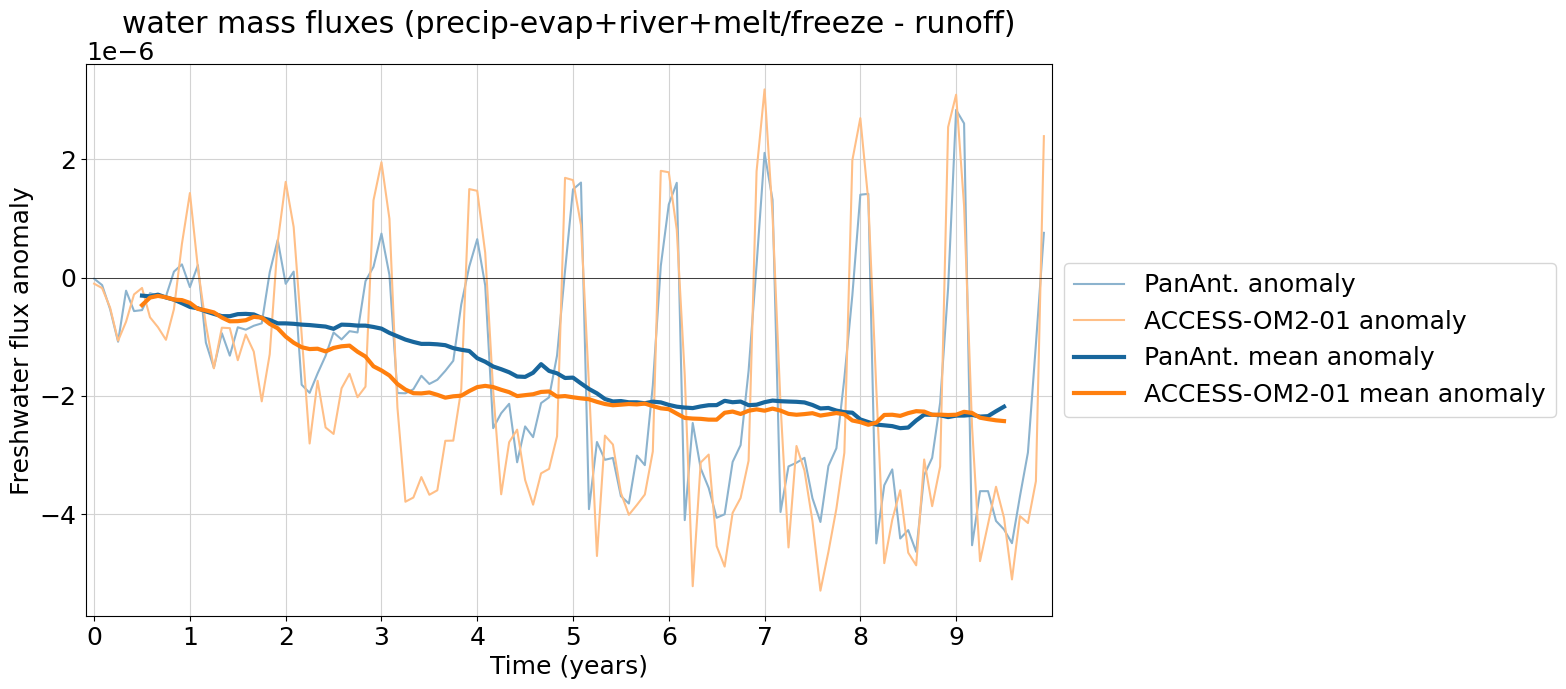

In [32]:
plt.rcParams['font.size'] = 18

plt.figure(figsize=(16, 7))

# Function to lighten color
def lighten(color, amount=0.4):
    c = np.array(to_rgba(color))
    return tuple(c[:3] + (1 - c[:3]) * amount)

# Compute 12-month rolling means

shelf_real_water_pan_C = shelf_water_pan_C_new - shelf_runoff_pan_C_new
shelf_real_water_pan_M = shelf_water_pan_M_new - shelf_runoff_pan_M_new
shelf_real_water_acc_C = shelf_water_acc_C_new - shelf_runoff_acc_C_new
shelf_real_water_acc_M = shelf_water_acc_M_new - shelf_runoff_acc_M_new

shelf_real_water_pan_C_rm = (shelf_water_pan_C_new - shelf_runoff_pan_C_new).rolling(window=12, center=True).mean()
shelf_real_water_pan_M_rm = (shelf_water_pan_M_new - shelf_runoff_pan_M_new).rolling(window=12, center=True).mean()
shelf_real_water_acc_C_rm = (shelf_water_acc_C_new - shelf_runoff_acc_C_new).rolling(window=12, center=True).mean()
shelf_real_water_acc_M_rm = (shelf_water_acc_M_new - shelf_runoff_acc_M_new).rolling(window=12, center=True).mean()


# Plot anomalies
plt.plot((shelf_real_water_pan_M - shelf_real_water_pan_C).index, (shelf_real_water_pan_M - shelf_real_water_pan_C).values,
         label='PanAnt. anomaly', color=lighten(colors['pan01_pre'],0.5), linestyle='-')
plt.plot((shelf_real_water_acc_M - shelf_real_water_acc_C).index, (shelf_real_water_acc_M - shelf_real_water_acc_C),
         label='ACCESS-OM2-01 anomaly', color=lighten(colors['access_pre'],0.5), linestyle='-')

# Plot rolling means
plt.plot((shelf_real_water_pan_M_rm - shelf_real_water_pan_C_rm).index, (shelf_real_water_pan_M_rm - shelf_real_water_pan_C_rm).values,
         label='PanAnt. mean anomaly', color=colors['pan01_pre'], linestyle='-', linewidth = 3)
plt.plot((shelf_real_water_acc_M_rm - shelf_real_water_acc_C_rm).index, (shelf_real_water_acc_M_rm - shelf_real_water_acc_C_rm).values,
         label='ACCESS-OM2-01 mean anomaly', color=colors['access_pre'], linestyle='-', linewidth = 3)

# Axis formatting
plt.xticks(ticks=range(1, 121, 12), labels=[str(i) for i in range(0, 10)])
plt.axhline(0, color='black', linewidth=0.5)
plt.xlabel('Time (years)')
plt.ylabel('Freshwater flux anomaly')
plt.legend(ncols=1, loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlim(0, 121)
plt.title('water mass fluxes (precip-evap+river+melt/freeze - runoff)')
#plt.ylim(-0.00002, 0.00003)
plt.grid(True, color='lightgrey')
plt.tight_layout()
plt.show()


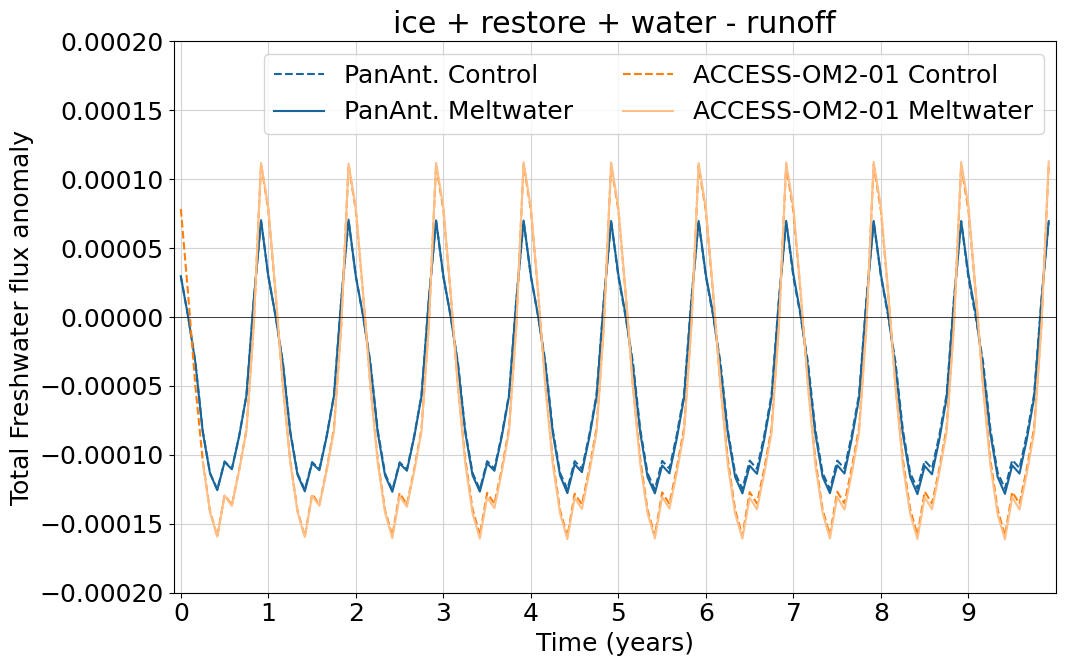

In [33]:

plt.rcParams['font.size'] = 18
plt.figure(figsize=(11, 7))

# Sum all the contributions for PanAntarctic
pan_cont_sum = (shelf_ice_pan_C_new + shelf_restore_pan_C_new +
                shelf_water_pan_C_new - shelf_runoff_pan_C_new)
pan_melt_sum = (shelf_ice_pan_M_new + shelf_restore_pan_M_new +
                shelf_water_pan_M_new - shelf_runoff_pan_M_new)

# Sum all the contributions for ACCESS-OM2-01
acc_cont_sum = (shelf_ice_acc_C_new + shelf_restore_acc_C_new +
                shelf_water_acc_C_new - shelf_runoff_acc_C_new)
acc_melt_sum = (shelf_ice_acc_M_new + shelf_restore_acc_M_new +
                shelf_water_acc_M_new - shelf_runoff_acc_M_new)

# Plotting PanAntarctic sums
plt.plot(pan_cont_sum.index, pan_cont_sum.values,
         label='PanAnt. Control', color=colors['pan01_pre'], linestyle='--')
plt.plot(pan_melt_sum.index, pan_melt_sum.values,
         label='PanAnt. Meltwater', color=colors['pan01_pre'], linestyle='-')

# Plotting ACCESS-OM2-01 sums (lighter purple for distinction)
from matplotlib.colors import to_rgba
def lighten(color, amount=0.5):
    c = np.array(to_rgba(color))
    return tuple(c[:3] + (1 - c[:3]) * amount)

plt.plot(acc_cont_sum.index, acc_cont_sum.values,
         label='ACCESS-OM2-01 Control', color=colors['access_pre'], linestyle='--')
plt.plot(acc_melt_sum.index, acc_melt_sum.values,
         label='ACCESS-OM2-01 Meltwater', color=lighten(colors['access_pre'], 0.5), linestyle='-')

# Axis formatting
plt.axhline(0, color='black', linewidth=0.5)
plt.xlabel('Time (years)')
plt.ylabel('Total Freshwater flux anomaly')
plt.xticks(ticks=range(1, 121, 12), labels=[str(i) for i in range(0, 10)])
plt.xlim(0, 121)
plt.ylim(-0.0002,0.0002)
plt.grid(True, color='lightgrey')
plt.title('ice + restore + water - runoff')
plt.legend(ncols=2)
plt.tight_layout()
plt.show()


In [34]:
# pan_cont_sum.to_netdf('/g/data/g40/kc5856/thesis_figures/data_files/surfaceflux_shelf_time_C_final_prescribed_pan01.nc')
# pan_melt_sum.to_netdf('/g/data/g40/kc5856/thesis_figures/data_files/surfaceflux_shelf_time_M_final_prescribed_pan01.nc')
# acc_cont_sum.to_netdf('/g/data/g40/kc5856/thesis_figures/data_files/surfaceflux_shelf_time_C_final_prescribed_access.nc')
# acc_melt_sum.to_netdf('/g/data/g40/kc5856/thesis_figures/data_files/surfaceflux_shelf_time_M_final_prescribed_access.nc')

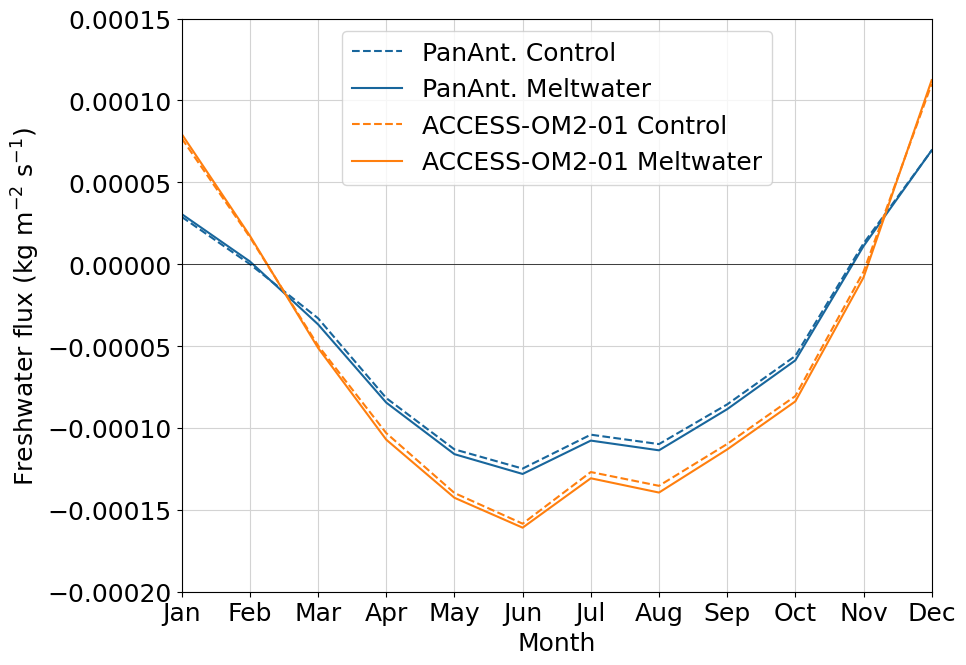

In [35]:
plt.rcParams['font.size'] = 18


# --- Function for 5-year monthly climatology with offset support ---
def five_year_climatology(series, start=60, end=120, offset=0):
    """
    Compute 5-year monthly climatology for a series (assumed monthly).
    offset: integer month offset (positive = shift forward in time)
    """
    # apply offset
    if offset != 0:
        series = series.shift(offset)

    # extract 5-year segment
    sub = series[start:end].dropna()
    n = (len(sub) // 12) * 12  # trim to full years
    sub = sub.iloc[:n]
    reshaped = sub.values.reshape(n // 12, 12)
    return reshaped.mean(axis=0)

# --- Compute climatologies ---
panC_clim = five_year_climatology(pan_cont_sum)
panM_clim = five_year_climatology(pan_melt_sum)
accC_clim = five_year_climatology(acc_cont_sum)
accM_clim = five_year_climatology(acc_melt_sum, offset=0)  # 4-month lag included here

# --- Plot ---
months = np.arange(1, 13)
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

plt.figure(figsize=(10, 7))
plt.plot(months, panC_clim, label='PanAnt. Control', color=colors['pan01_pre'], linestyle='--')
plt.plot(months, panM_clim, label='PanAnt. Meltwater', color=colors['pan01_pre'], linestyle='-')
plt.plot(months, accC_clim, label='ACCESS-OM2-01 Control', color=colors['access_pre'], linestyle='--')
plt.plot(months, accM_clim, label='ACCESS-OM2-01 Meltwater', color=colors['access_pre'], linestyle='-')

plt.axhline(0, color='black', linewidth=0.5)
plt.xticks(months, month_labels)
plt.xlabel('Month')
plt.ylabel('Freshwater flux (kg m$^{-2}$ s$^{-1}$)')
#plt.title('5-year climatology (salt + water - runoff)')
plt.legend(ncols=1,loc='upper center')
plt.xlim(1, 12)
plt.ylim(-0.0002, 0.00015)
plt.grid(True, color='lightgrey')
plt.tight_layout()
plt.show()


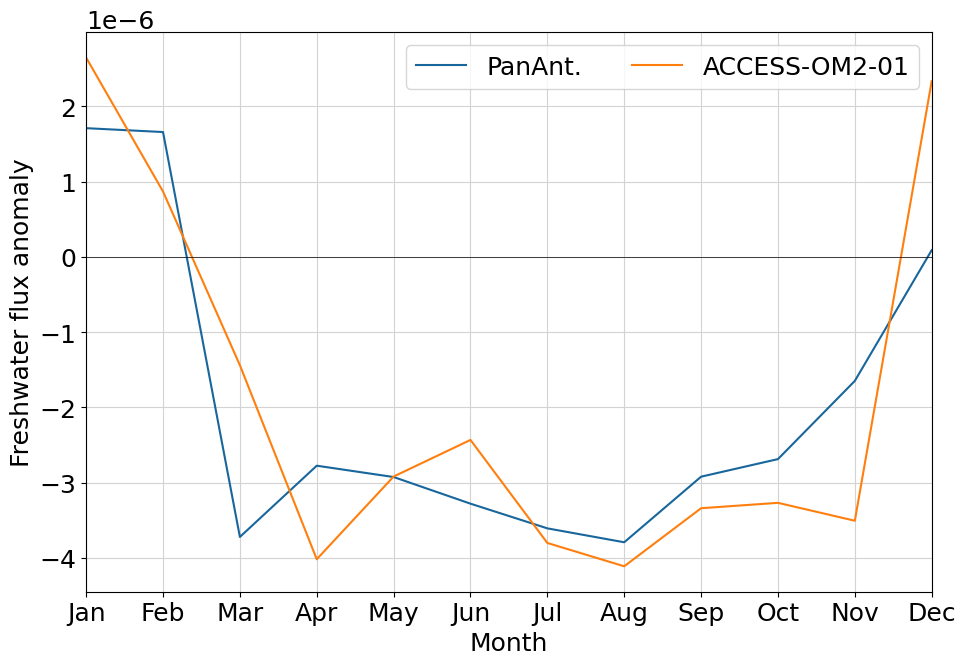

In [36]:
plt.rcParams['font.size'] = 18

pan_anom_clim = panM_clim - panC_clim
acc_anom_clim = accM_clim - accC_clim

# --- Plot ---
months = np.arange(1, 13)
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

plt.figure(figsize=(10, 7))
plt.plot(months, pan_anom_clim, label='PanAnt.', color=colors['pan01_pre'], linestyle='-')
plt.plot(months, acc_anom_clim, label='ACCESS-OM2-01', color=colors['access_pre'], linestyle='-')

plt.axhline(0, color='black', linewidth=0.5)
plt.xticks(months, month_labels)
plt.xlabel('Month')
plt.ylabel('Freshwater flux anomaly')
#plt.title('5-year climatology (salt + water - runoff)')
plt.legend(ncols=2)
plt.xlim(1, 12)
#plt.ylim(-0.00028, 0.00015)
plt.grid(True, color='lightgrey')
plt.tight_layout()
plt.show()


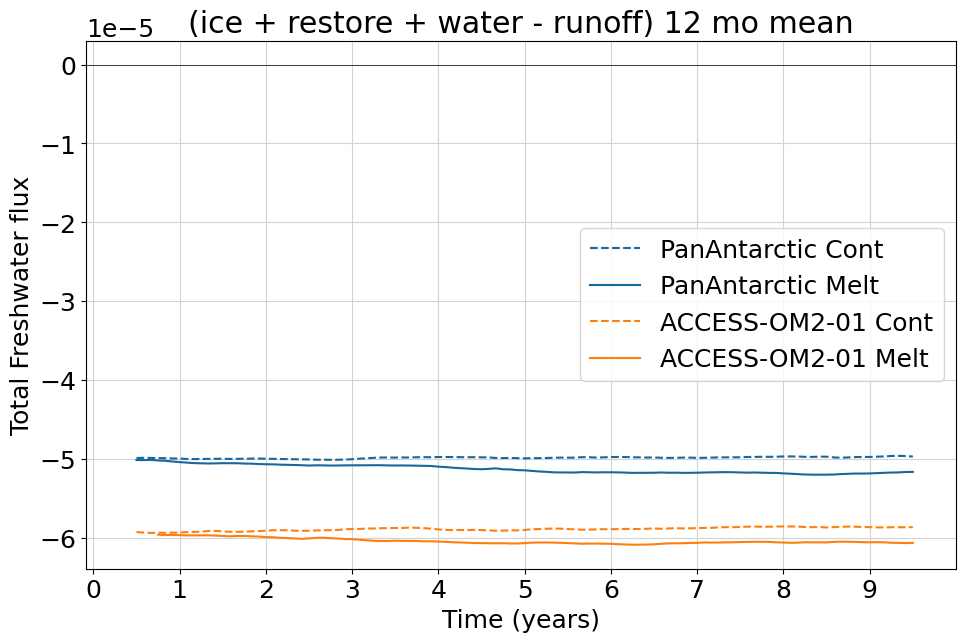

In [37]:
plt.rcParams['font.size'] = 18
plt.figure(figsize=(10, 7))

# Apply 12-month rolling mean
pan_cont_roll = pan_cont_sum.rolling(window=12, center=True).mean()
pan_melt_roll = pan_melt_sum.rolling(window=12, center=True).mean()
acc_cont_roll = acc_cont_sum.rolling(window=12, center=True).mean()
acc_melt_roll = acc_melt_sum.rolling(window=12, center=True).mean()

# Function to lighten color
def lighten(color, amount=0.5):
    c = np.array(to_rgba(color))
    return tuple(c[:3] + (1 - c[:3]) * amount)

# Plotting smoothed sums
plt.plot(pan_cont_roll.index, pan_cont_roll.values,
         label='PanAntarctic Cont', color=colors['pan01_pre'], linestyle='--')
plt.plot(pan_melt_roll.index, pan_melt_roll.values,
         label='PanAntarctic Melt', color=colors['pan01_pre'], linestyle='-')
plt.plot(acc_cont_roll.index, acc_cont_roll.values,
         label='ACCESS-OM2-01 Cont', color=colors['access_pre'], linestyle='--')
plt.plot(acc_melt_roll.index, acc_melt_roll.values,
         label='ACCESS-OM2-01 Melt', color=colors['access_pre'], linestyle='-')

# Axis formatting
plt.axhline(0, color='black', linewidth=0.5)
plt.xlabel('Time (years)')
plt.ylabel('Total Freshwater flux')
plt.xticks(ticks=range(1, 121, 12), labels=[str(i) for i in range(0, 10)])
plt.xlim(0, 121)
plt.grid(True, color='lightgrey')
plt.title('(ice + restore + water - runoff) 12 mo mean')
plt.legend()
plt.tight_layout()
plt.show()


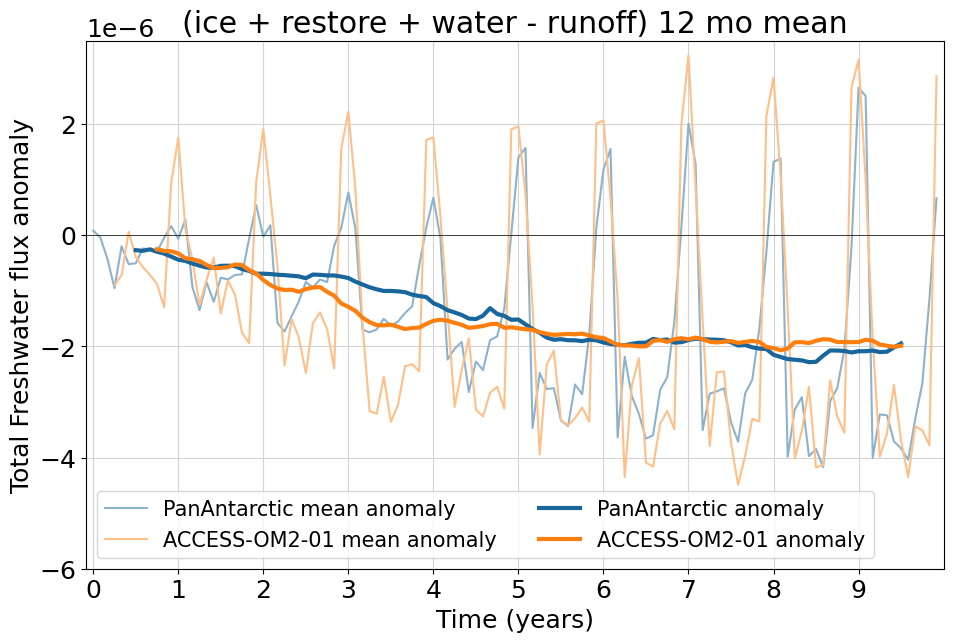

In [38]:
plt.rcParams['font.size'] = 18
plt.figure(figsize=(10, 7))

# Apply 12-month rolling mean
pan_anom = pan_melt_sum - pan_cont_sum
acc_anom = acc_melt_sum - acc_cont_sum

pan_anom_roll = pan_melt_sum.rolling(window=12, center=True).mean() - pan_cont_sum.rolling(window=12, center=True).mean()
acc_anom_roll = acc_melt_sum.rolling(window=12, center=True).mean() - acc_cont_sum.rolling(window=12, center=True).mean()

# Function to lighten color
def lighten(color, amount=0.5):
    c = np.array(to_rgba(color))
    return tuple(c[:3] + (1 - c[:3]) * amount)

# Plotting sums
plt.plot(pan_anom.index, pan_anom.values,
         label='PanAntarctic mean anomaly', color=lighten(colors['pan01_pre'],0.5), linestyle='-')
plt.plot(acc_anom.index, acc_anom.values,
         label='ACCESS-OM2-01 mean anomaly', color=lighten(colors['access_pre'], 0.5), linestyle='-')
             
# Plotting smoothed sums
plt.plot(pan_anom_roll.index, pan_anom_roll.values,
         label='PanAntarctic anomaly', color=colors['pan01_pre'], linestyle='-', linewidth=3)
plt.plot(acc_anom_roll.index, acc_anom_roll.values,
         label='ACCESS-OM2-01 anomaly', color=colors['access_pre'], linestyle='-', linewidth=3)

# Axis formatting
plt.axhline(0, color='black', linewidth=0.5)
plt.xlabel('Time (years)')
plt.ylabel('Total Freshwater flux anomaly')
plt.xticks(ticks=range(1, 121, 12), labels=[str(i) for i in range(0, 10)])
plt.xlim(0, 121)
plt.ylim (-6e-6,3.5e-6)
plt.grid(True, color='lightgrey')
plt.title('(ice + restore + water - runoff) 12 mo mean')
plt.legend(loc='lower left',ncol=2,fontsize=15)
plt.tight_layout()
plt.show()


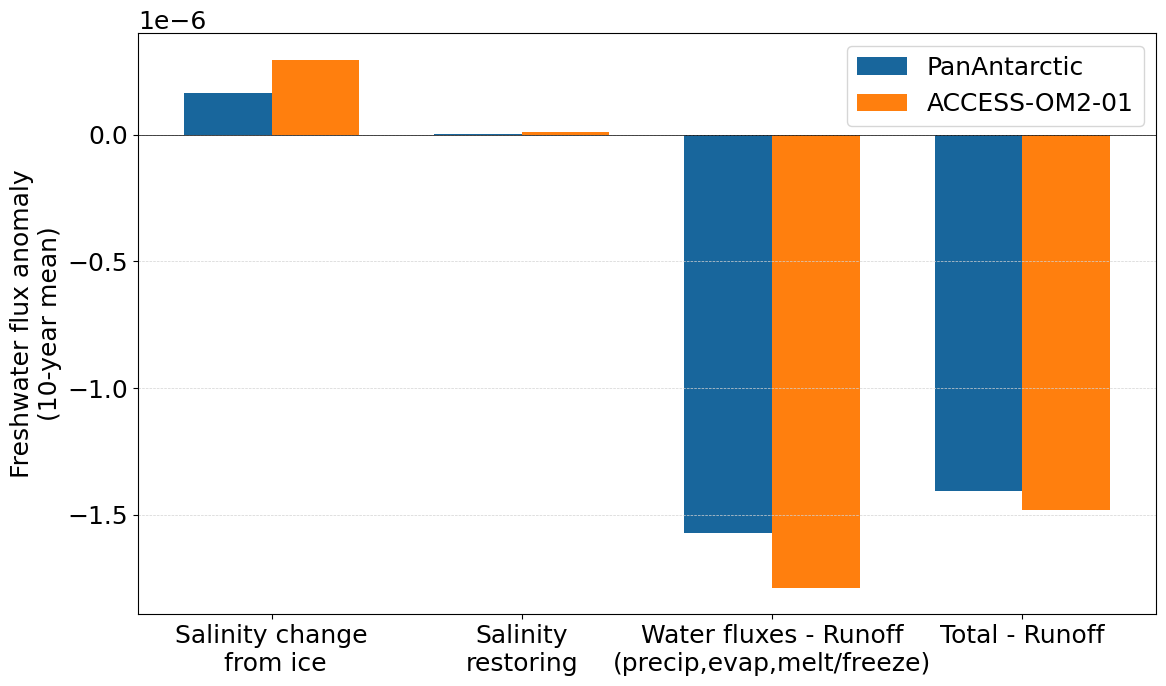

In [39]:
# --- Functions to compute total mean ---
def total_mean(anom):
    return np.nanmean(anom)

# --- Compute total 10-year means ---
def compute_total_means(an_ice, an_rest, an_real_water):
    ice_mean   = total_mean(an_ice)
    rest_mean  = total_mean(an_rest)
    real_water_mean = total_mean(an_real_water)
    total = ice_mean + rest_mean + real_water_mean
    return [ice_mean, rest_mean, real_water_mean, total]

# Compute for PanAntarctic
pan_means_total = compute_total_means(an_pan_ice, an_pan_rest, an_pan_real_water)

# Compute for ACCESS-OM2-01
acc_means_total = compute_total_means(an_acc_ice, an_acc_rest, an_acc_real_water)

# --- Prepare bar positions ---
labels = ['Salinity change\n from ice', 'Salinity\nrestoring', 'Water fluxes - Runoff\n(precip,evap,melt/freeze)', 'Total - Runoff']
x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(12,7.2))

# PanAntarctic
plt.bar(x - width/2, pan_means_total, width, color=colors['pan01_pre'],
        label='PanAntarctic')

# ACCESS-OM2-01
plt.bar(x + width/2, acc_means_total, width, color=colors['access_pre'],
        label='ACCESS-OM2-01')

# --- Formatting ---
plt.xticks(x, labels)
plt.ylabel('Freshwater flux anomaly\n(10-year mean)')
#plt.title('Total 10-year mean freshwater fluxes with combined total')
plt.axhline(0, color='black', linewidth=0.5)
plt.grid(True, axis='y', color='lightgrey', linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()


In [46]:
# Ten year anomalies for PanAntarctic
pan_means_total = compute_total_means(an_pan_ice, an_pan_rest, an_pan_real_water)
pan_means_total

[1.6284564e-07, 8.743436429257838e-10, -1.57131e-06, -1.4075900272682075e-06]

In [47]:
# Ten year anomalies for PanAntarctic
acc_means_total = compute_total_means(an_acc_ice, an_acc_rest, an_acc_real_water)
acc_means_total

[2.9608398e-07, 1.008091733362991e-08, -1.7892157e-06, -1.4830508306868298e-06]

Last 5 years:

In [42]:
# Last 5 year anomalies for PanAntarctic
pan_means_total = compute_total_means(an_pan_ice[-60:], an_pan_rest[-60:], an_pan_real_water[-60:])
pan_means_total

[2.3080644e-07, 8.703346629529901e-10, -2.2242455e-06, -1.992568693406635e-06]

In [43]:
# Last 5 year anomalies for ACCESS-OM2-01
acc_means_total = compute_total_means(an_acc_ice[-60:], an_acc_rest[-60:], an_acc_real_water[-60:])
acc_means_total

[3.781498e-07, 1.8803488575195603e-08, -2.3134064e-06, -1.916453131269754e-06]

First five years:

In [48]:
# First 5 year anomalies for PanAntarctic
pan_means_total = compute_total_means(an_pan_ice[:60], an_pan_rest[:60], an_pan_real_water[:60])
pan_means_total

[9.488482e-08, 8.783526228985775e-10, -9.1837444e-07, -8.226112687592244e-07]

In [49]:
# First 5 year anomalies for ACCESS-OM2-01
acc_means_total = compute_total_means(an_acc_ice[:60], an_acc_rest[:60], an_acc_real_water[:60])
acc_means_total

[2.1401812e-07,
 1.3076354658236446e-08,
 -1.2650252e-06,
 -1.0379306920679903e-06]

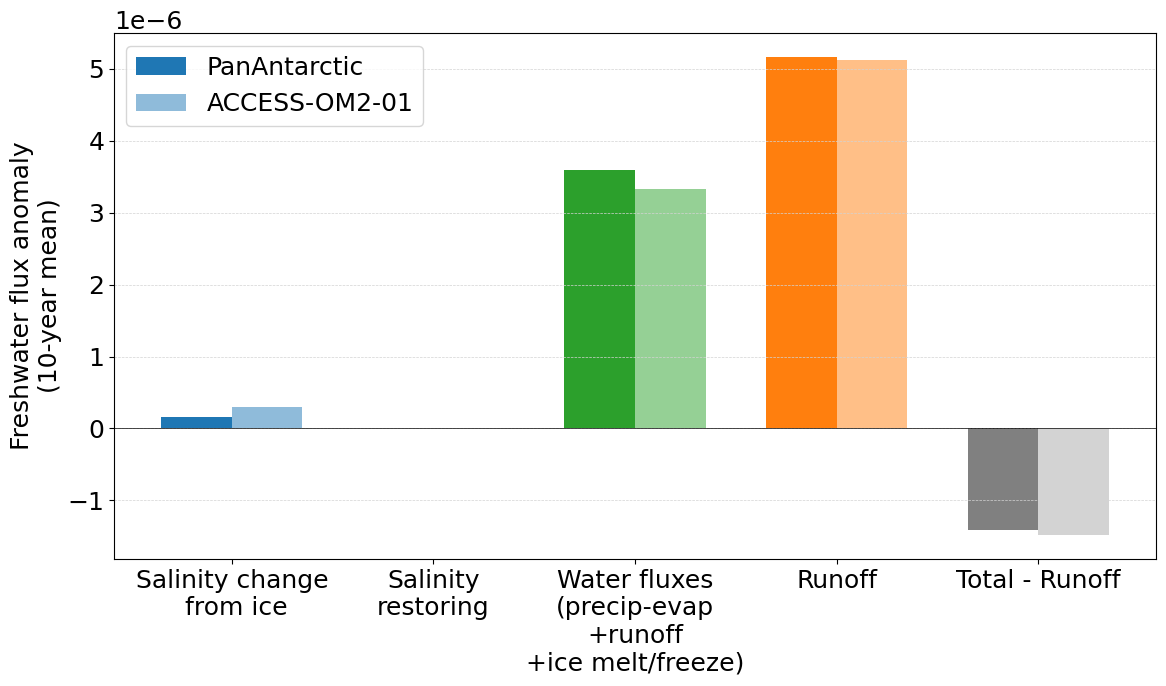

In [55]:
# --- Functions to compute total mean ---
def total_mean(anom):
    return np.nanmean(anom)

# --- Compute total 10-year means ---
def compute_total_means(an_ice, an_rest, an_water, an_run):
    ice_mean   = total_mean(an_ice)
    rest_mean  = total_mean(an_rest)
    water_mean = total_mean(an_water)
    run_mean   = total_mean(an_run)
    total = ice_mean + rest_mean + water_mean - run_mean
    return [ice_mean, rest_mean, water_mean, run_mean, total]

# Compute for PanAntarctic
pan_means_total = compute_total_means(an_pan_ice, an_pan_rest, an_pan_water, an_pan_run)

# Compute for ACCESS-OM2-01
acc_means_total = compute_total_means(an_acc_ice, an_acc_rest, an_acc_water, an_acc_run)

# --- Prepare bar positions ---
labels = ['Salinity change\n from ice', 'Salinity\nrestoring', 'Water fluxes\n(precip-evap\n+runoff\n+ice melt/freeze)', 'Runoff', 'Total - Runoff']
x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(12,7.2))

# PanAntarctic
plt.bar(x - width/2, pan_means_total, width, color=[forcing_colors['ice'], forcing_colors['restore'],
                                                   forcing_colors['water'], forcing_colors['runoff'], 'grey'],
        label='PanAntarctic')

# ACCESS-OM2-01
plt.bar(x + width/2, acc_means_total, width, color=[lighten(forcing_colors['ice'],0.5), 
                                                    lighten(forcing_colors['restore'],0.5),
                                                    lighten(forcing_colors['water'],0.5),
                                                    lighten(forcing_colors['runoff'],0.5), 
                                                    'lightgrey'],
        label='ACCESS-OM2-01')

# --- Formatting ---
plt.xticks(x, labels)
plt.ylabel('Freshwater flux anomaly\n(10-year mean)')
#plt.title('Total 10-year mean freshwater fluxes with combined total')
plt.axhline(0, color='black', linewidth=0.5)
plt.grid(True, axis='y', color='lightgrey', linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()


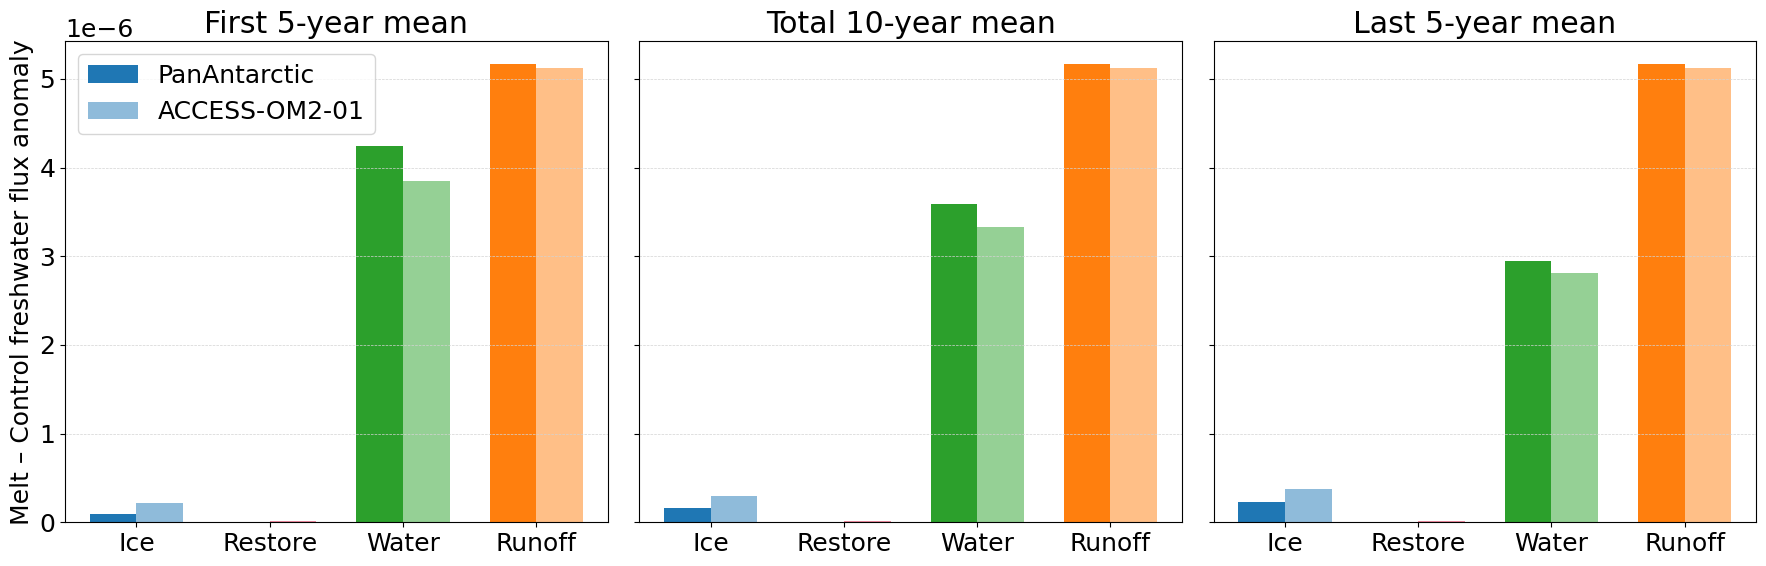

In [51]:
# --- Functions to compute means ---
def first5_mean(anom):
    return np.nanmean(anom[:60])

def total_mean(anom):
    return np.nanmean(anom)

def last5_mean(anom):
    return np.nanmean(anom[-60:])

# --- Compute means ---
def compute_means(an_ice, an_rest, an_water, an_run):
    return [first5_mean(an_ice), first5_mean(an_rest), first5_mean(an_water), first5_mean(an_run)], \
           [total_mean(an_ice), total_mean(an_rest), total_mean(an_water), total_mean(an_run)], \
           [last5_mean(an_ice), last5_mean(an_rest), last5_mean(an_water), last5_mean(an_run)]

pan_means_1st5, pan_means_total, pan_means_last5 = compute_means(an_pan_ice, an_pan_rest, an_pan_water, an_pan_run)
acc_means_1st5, acc_means_total, acc_means_last5 = compute_means(an_acc_ice, an_acc_rest, an_acc_water, an_acc_run)

# --- Prepare bar positions ---
labels = ['Ice', 'Restore', 'Water', 'Runoff']
x = np.arange(len(labels))
width = 0.35

# --- Create figure with 3 subplots ---
fig, axes = plt.subplots(1, 3, figsize=(18,6), sharey=True)

for ax, pan_means, acc_means, title in zip(
    axes,
    [pan_means_1st5, pan_means_total, pan_means_last5],
    [acc_means_1st5, acc_means_total, acc_means_last5],
    ['First 5-year mean', 'Total 10-year mean', 'Last 5-year mean']
):
    ax.bar(x - width/2, pan_means, width, color=[forcing_colors['ice'], forcing_colors['restore'],
                                                 forcing_colors['water'], forcing_colors['runoff']],
           label='PanAntarctic')
    ax.bar(x + width/2, acc_means, width, color=[lighten(forcing_colors['ice'],0.5), 
                                                 lighten(forcing_colors['restore'],0.5),
                                                 lighten(forcing_colors['water'],0.5),
                                                 lighten(forcing_colors['runoff'],0.5)],
           label='ACCESS-OM2-01')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.axhline(0, color='black', linewidth=0.5)
    ax.set_title(title)
    ax.grid(True, axis='y', color='lightgrey', linestyle='--', linewidth=0.5)

# --- Formatting ---
axes[0].set_ylabel('Melt – Control freshwater flux anomaly')
axes[0].legend()
plt.tight_layout()
plt.show()


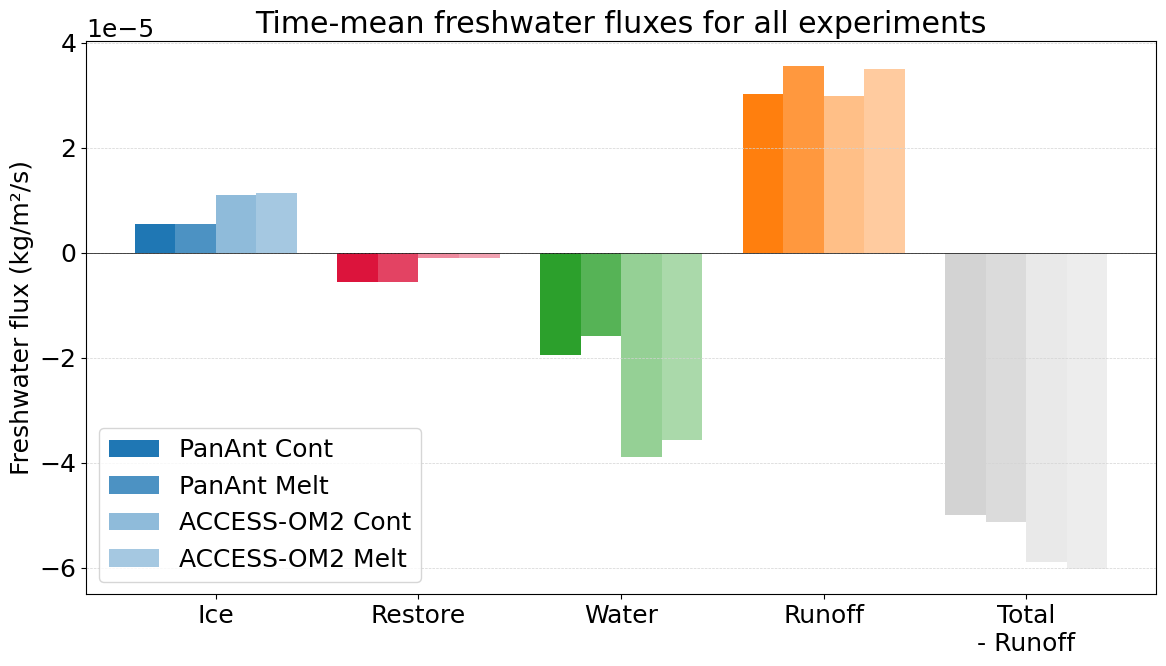

In [52]:
# --- Lighten color function ---
def lighten(color, amount=0.4):
    c = np.array(to_rgba(color))
    return tuple(c[:3] + (1 - c[:3]) * amount)

# --- Define colors per forcing type ---
forcing_colors = {
    'Ice': '#1f77b4',       # blue
    'Restore': 'crimson',   # red
    'Water': '#2ca02c',     # green
    'Runoff': '#ff7f0e',    # orange
    'Total\n- Runoff': 'lightgrey'
}

# --- Compute time means (over full time series, all months) ---
def time_mean(series):
    return np.nanmean(series.values)

def compute_total_means(ice, rest, water, run):
    ice_mean   = time_mean(ice)
    rest_mean  = time_mean(rest)
    water_mean = time_mean(water)
    run_mean   = time_mean(run)
    total = ice_mean + rest_mean + water_mean - run_mean  # sum of components
    return [ice_mean, rest_mean, water_mean, run_mean, total]

# --- Compute means for each model and experiment ---
pan_C = compute_total_means(shelf_ice_pan_C_new, shelf_restore_pan_C_new, shelf_water_pan_C_new, shelf_runoff_pan_C_new)
pan_M = compute_total_means(shelf_ice_pan_M_new, shelf_restore_pan_M_new, shelf_water_pan_M_new, shelf_runoff_pan_M_new)

acc_C = compute_total_means(shelf_ice_acc_C_new, shelf_restore_acc_C_new, shelf_water_acc_C_new, shelf_runoff_acc_C_new)
acc_M = compute_total_means(shelf_ice_acc_M_new, shelf_restore_acc_M_new, shelf_water_acc_M_new, shelf_runoff_acc_M_new)

# --- Bar plot ---
labels = ['Ice', 'Restore', 'Water', 'Runoff', 'Total\n- Runoff']
x = np.arange(len(labels))
width = 0.2  # width of each bar

plt.figure(figsize=(12,7))

for i, label in enumerate(labels):
    color = forcing_colors[label]
    plt.bar(x[i] - 1.5*width, pan_C[i], width, color=color, label='PanAnt Cont' if i==0 else "")
    plt.bar(x[i] - 0.5*width, pan_M[i], width, color=color, alpha=0.8, label='PanAnt Melt' if i==0 else "")
    plt.bar(x[i] + 0.5*width, acc_C[i], width, color=lighten(color, 0.5), label='ACCESS-OM2 Cont' if i==0 else "")
    plt.bar(x[i] + 1.5*width, acc_M[i], width, color=lighten(color, 0.5), alpha=0.8, label='ACCESS-OM2 Melt' if i==0 else "")

# Formatting
plt.xticks(x, labels)
plt.ylabel('Freshwater flux (kg/m²/s)')
plt.title('Time-mean freshwater fluxes for all experiments')
plt.axhline(0, color='black', linewidth=0.5)
plt.grid(True, axis='y', color='lightgrey', linestyle='--', linewidth=0.5)
plt.legend(ncol=1)
plt.tight_layout()
plt.show()


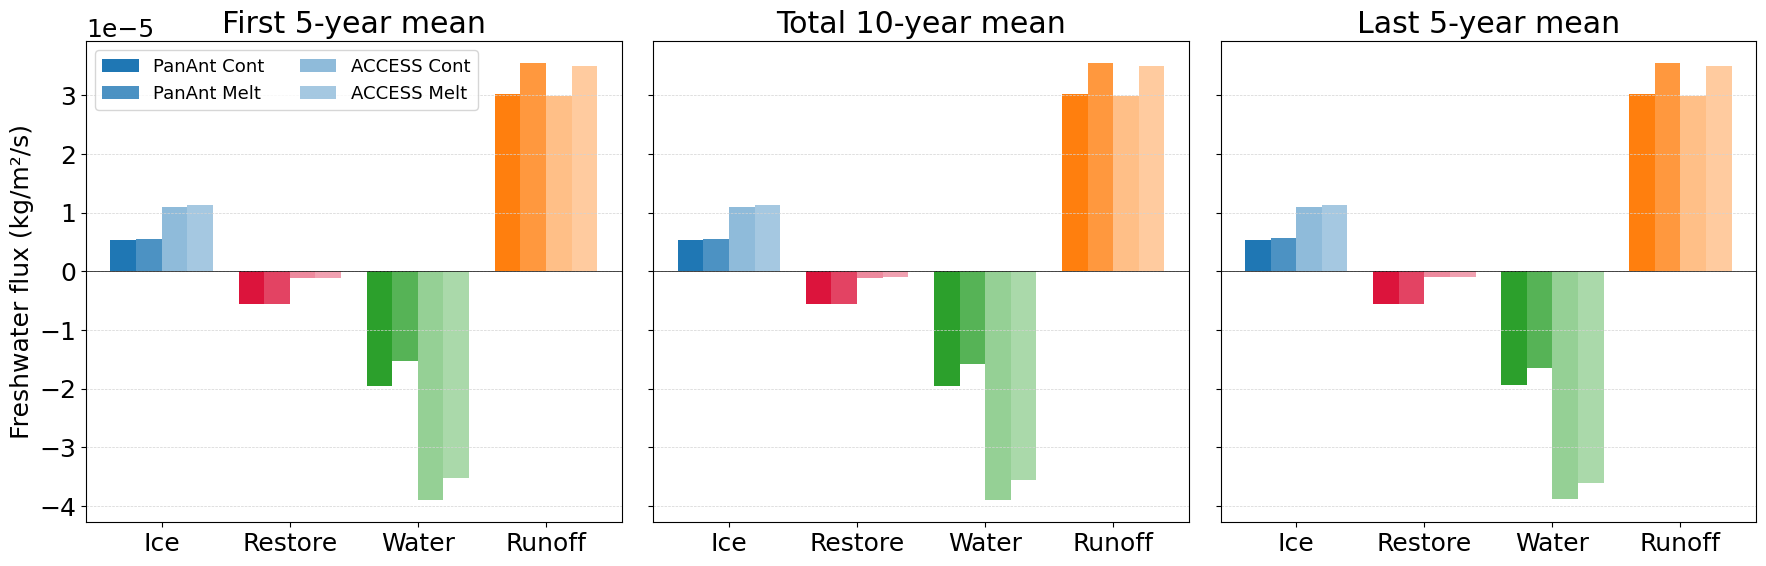

In [53]:
# --- Lighten color function ---
def lighten(color, amount=0.4):
    c = np.array(to_rgba(color))
    return tuple(c[:3] + (1 - c[:3]) * amount)

# --- Colors per forcing type ---
forcing_colors = {
    'ice': '#1f77b4',
    'restore': 'crimson',
    'water': '#2ca02c',
    'runoff': '#ff7f0e'
}

# --- Functions to compute means ---
def first5_mean(series):
    return np.nanmean(series.values[:60])

def last5_mean(series):
    return np.nanmean(series.values[-60:])

def total_mean(series):
    return np.nanmean(series.values)

# --- Compute means for all experiments ---
def compute_all_means(model_series):
    # model_series = [ice_C, ice_M, restore_C, restore_M, water_C, water_M, runoff_C, runoff_M]
    means_first5 = [first5_mean(s) for s in model_series]
    means_total  = [total_mean(s) for s in model_series]
    means_last5  = [last5_mean(s) for s in model_series]
    return means_first5, means_total, means_last5

# PanAntarctic
pan_series = [shelf_ice_pan_C_new, shelf_ice_pan_M_new,
              shelf_restore_pan_C_new, shelf_restore_pan_M_new,
              shelf_water_pan_C_new, shelf_water_pan_M_new,
              shelf_runoff_pan_C_new, shelf_runoff_pan_M_new]

pan_first5, pan_total, pan_last5 = compute_all_means(pan_series)

# ACCESS-OM2-01
acc_series = [shelf_ice_acc_C_new, shelf_ice_acc_M_new,
              shelf_restore_acc_C_new, shelf_restore_acc_M_new,
              shelf_water_acc_C_new, shelf_water_acc_M_new,
              shelf_runoff_acc_C_new, shelf_runoff_acc_M_new]

acc_first5, acc_total, acc_last5 = compute_all_means(acc_series)

# --- Bar plot positions ---
labels = ['Ice', 'Restore', 'Water', 'Runoff']
x = np.arange(len(labels))
width = 0.2  # width of each bar

# --- Create figure with 3 subplots ---
fig, axes = plt.subplots(1, 3, figsize=(18,6), sharey=True)

for ax, pan_means, acc_means, title in zip(
    axes,
    [pan_first5, pan_total, pan_last5],
    [acc_first5, acc_total, acc_last5],
    ['First 5-year mean', 'Total 10-year mean', 'Last 5-year mean']
):
    for i, label in enumerate(labels):
        # PanAntarctic Control and Melt
        ax.bar(x[i] - 1.5*width, pan_means[2*i], width, color=forcing_colors[label.lower()], label='PanAnt Cont' if i==0 else "")
        ax.bar(x[i] - 0.5*width, pan_means[2*i+1], width, color=forcing_colors[label.lower()], alpha=0.8, label='PanAnt Melt' if i==0 else "")
        # ACCESS-OM2 Control and Melt
        ax.bar(x[i] + 0.5*width, acc_means[2*i], width, color=lighten(forcing_colors[label.lower()], 0.5), label='ACCESS Cont' if i==0 else "")
        ax.bar(x[i] + 1.5*width, acc_means[2*i+1], width, color=lighten(forcing_colors[label.lower()], 0.5), alpha=0.8, label='ACCESS Melt' if i==0 else "")
    
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.axhline(0, color='black', linewidth=0.5)
    ax.set_title(title)
    ax.grid(True, axis='y', color='lightgrey', linestyle='--', linewidth=0.5)

# --- Formatting ---
axes[0].set_ylabel('Freshwater flux (kg/m²/s)')
axes[0].legend(ncol=2, loc='upper left', fontsize = 13)
plt.tight_layout()
plt.show()


In [54]:
pan_first5, pan_total, pan_last5 = compute_all_means(pan_series)
pan_last5

[5.405297e-06,
 5.636103e-06,
 -5.544186246905125e-06,
 -5.543315912242172e-06,
 -1.9332789e-05,
 -1.6391145e-05,
 3.0312996e-05,
 3.5478886e-05]

# Trying combined figures (not rerun yet) 

In [53]:
from matplotlib.colors import to_rgba
from matplotlib import gridspec

def lighten(color, amount=0.5):
    c = np.array(to_rgba(color))
    return tuple(c[:3] + (1 - c[:3]) * amount)

In [54]:
# Defining things for first plot 
pan_anom = pan_melt_sum - pan_cont_sum
acc_anom = acc_melt_sum - acc_cont_sum
pan_anom_roll = pan_melt_sum.rolling(window=12, center=True).mean() - pan_cont_sum.rolling(window=12, center=True).mean()
acc_anom_roll = acc_melt_sum.rolling(window=12, center=True).mean() - acc_cont_sum.rolling(window=12, center=True).mean()

# Defining things for second plot
panC_clim = five_year_climatology(pan_cont_sum)
panM_clim = five_year_climatology(pan_melt_sum)
accC_clim = five_year_climatology(acc_cont_sum)
accM_clim = five_year_climatology(acc_melt_sum)

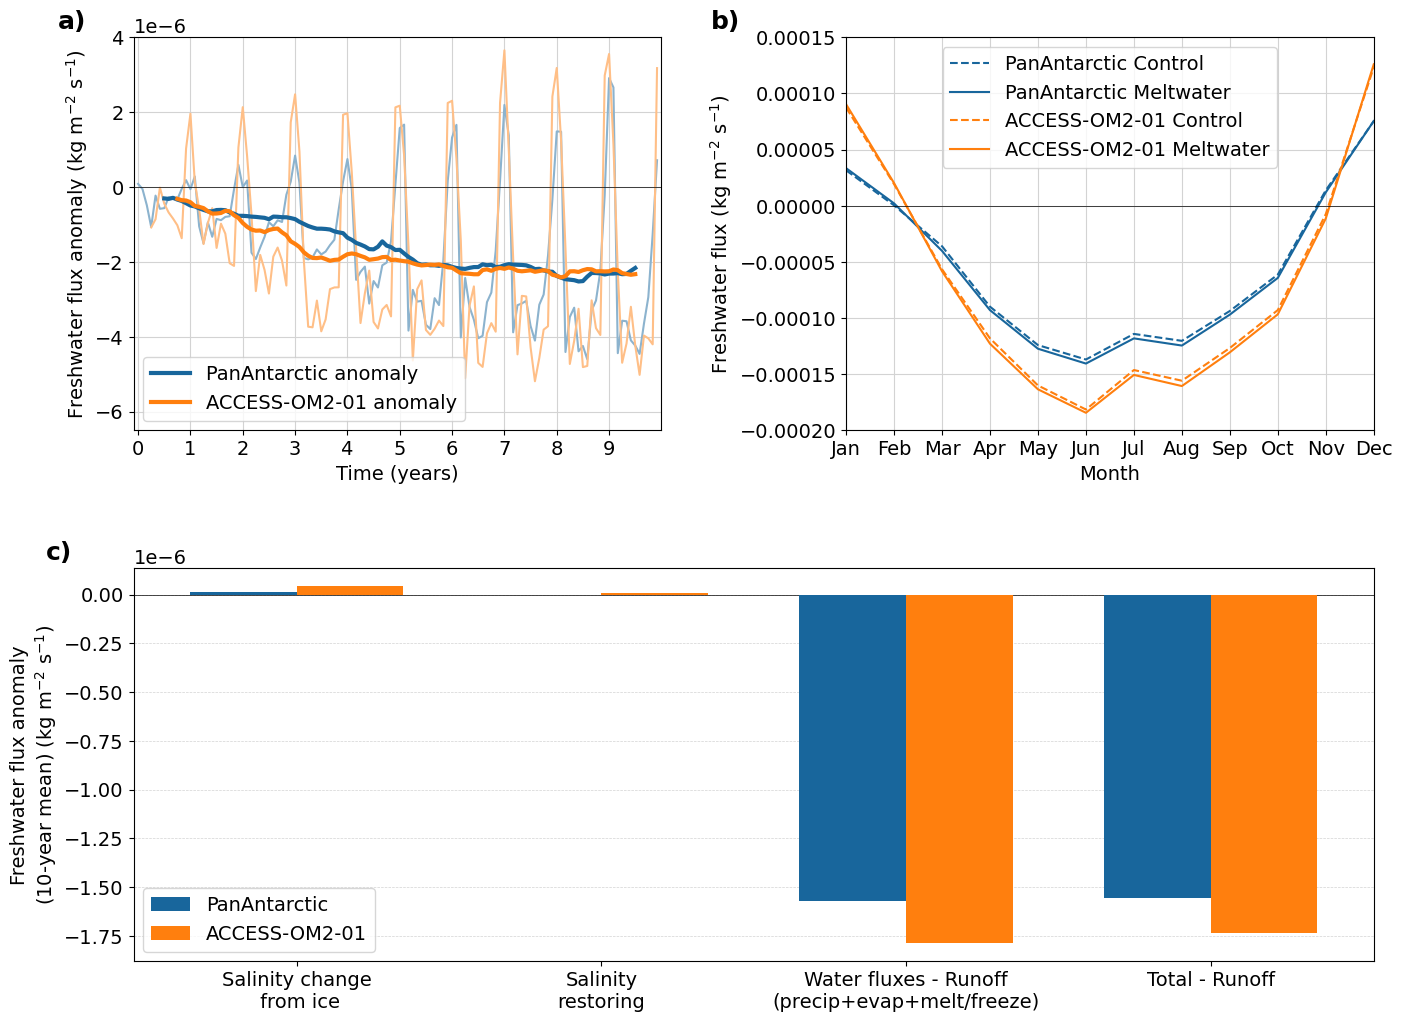

In [123]:
plt.rcParams['font.size'] = 14

# --- Create figure and layout ---
fig = plt.figure(figsize=(16, 12), constrained_layout=True)
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1], hspace=0.35, wspace=0.35)

# --- Top-left subplot (first plot) ---
ax1 = fig.add_subplot(gs[0, 0])

ax1.plot(pan_anom.index, pan_anom.values,
         color=lighten(colors['pan01_pre'],0.5), linestyle='-')
ax1.plot(acc_anom.index, acc_anom.values,
         color=lighten(colors['access_pre'], 0.5), linestyle='-')
ax1.plot(pan_anom_roll.index, pan_anom_roll.values,
         label='PanAntarctic anomaly', color=colors['pan01_pre'], linestyle='-', linewidth=3)
ax1.plot(acc_anom_roll.index, acc_anom_roll.values,
         label='ACCESS-OM2-01 anomaly', color=colors['access_pre'], linestyle='-', linewidth=3)

ax1.axhline(0, color='black', linewidth=0.5)
ax1.set_xlabel('Time (years)')
ax1.set_ylabel('Freshwater flux anomaly (kg m$^{-2}$ s$^{-1}$)')
ax1.set_xticks(range(1, 121, 12))
ax1.set_xticklabels([str(i) for i in range(0, 10)])
ax1.set_xlim(0, 121)
ax1.set_ylim(-6.5e-6, 4e-6)
ax1.grid(True, color='lightgrey')
#ax1.set_title('(ice + restore + water - runoff) 12 mo mean')
ax1.legend(loc='lower left', ncol=1, fontsize=14)

# --- Add (a) label ---
ax1.text(-0.09, 1.07, 'a)', transform=ax1.transAxes,
         fontsize=18, fontweight='bold', va='top', ha='right')

# --- Top-right subplot (second plot) ---
ax2 = fig.add_subplot(gs[0, 1])
months = np.arange(1, 13)
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

ax2.plot(months, panC_clim, label='PanAntarctic Control', color=colors['pan01_pre'], linestyle='--')
ax2.plot(months, panM_clim, label='PanAntarctic Meltwater', color=colors['pan01_pre'], linestyle='-')
ax2.plot(months, accC_clim, label='ACCESS-OM2-01 Control', color=colors['access_pre'], linestyle='--')
ax2.plot(months, accM_clim, label='ACCESS-OM2-01 Meltwater', color=colors['access_pre'], linestyle='-')

ax2.axhline(0, color='black', linewidth=0.5)
ax2.set_xticks(months)
ax2.set_xticklabels(month_labels)
ax2.set_xlabel('Month')
ax2.set_ylabel('Freshwater flux (kg m$^{-2}$ s$^{-1}$)')
ax2.legend(ncols=1, loc='upper center')
ax2.set_xlim(1, 12)
ax2.set_ylim(-0.0002, 0.00015)
ax2.grid(True, color='lightgrey')
#ax2.set_title('5-year climatology')

# --- Add (b) label ---
ax2.text(-0.2, 1.07, 'b)', transform=ax2.transAxes,
         fontsize=18, fontweight='bold', va='top', ha='right')

# --- Bottom-center subplot (your third plot, smaller width) ---
ax3 = fig.add_subplot(gs[1,:])  # places it centered below the two
labels = ['Salinity change\n from ice', 'Salinity\nrestoring',
          'Water fluxes - Runoff\n(precip+evap+melt/freeze)', 'Total - Runoff']
x = np.arange(len(labels))
width = 0.35

pan_means_total = compute_total_means(an_pan_ice, an_pan_rest, an_pan_real_water)
acc_means_total = compute_total_means(an_acc_ice, an_acc_rest, an_acc_real_water)

ax3.grid(True, axis='y', color='lightgrey', linestyle='--', linewidth=0.5)
ax3.set_xticks(x)
ax3.set_xticklabels(labels)
ax3.set_ylabel('Freshwater flux anomaly\n(10-year mean) (kg m$^{-2}$ s$^{-1}$)')
ax3.axhline(0, color='black', linewidth=0.5)

ax3.bar(x - width/2, pan_means_total, width, color=colors['pan01_pre'], label='PanAntarctic', zorder =10)
ax3.bar(x + width/2, acc_means_total, width, color=colors['access_pre'], label='ACCESS-OM2-01', zorder =10)



ax3.legend()
#ax3.set_title('Total 10-year mean fluxes')

# --- Add (c) label ---
ax3.text(-0.05, 1.07, 'c)', transform=ax3.transAxes,
         fontsize=18, fontweight='bold', va='top', ha='right')

#plt.tight_layout()
fig.savefig("/g/data/g40/kc5856/thesis_figures/intermodel_surfaceflux_overview.png", dpi=300, bbox_inches='tight')
plt.show()


In [85]:
# Defining things for the plot below
## First plot
shelf_real_water_pan_C = shelf_water_pan_C_new - shelf_runoff_pan_C_new
shelf_real_water_pan_M = shelf_water_pan_M_new - shelf_runoff_pan_M_new
shelf_real_water_acc_C = shelf_water_acc_C_new - shelf_runoff_acc_C_new
shelf_real_water_acc_M = shelf_water_acc_M_new - shelf_runoff_acc_M_new

# Rolling means
shelf_real_water_pan_C_rm = shelf_real_water_pan_C.rolling(window=12, center=True).mean()
shelf_real_water_pan_M_rm = shelf_real_water_pan_M.rolling(window=12, center=True).mean()
shelf_real_water_acc_C_rm = shelf_real_water_acc_C.rolling(window=12, center=True).mean()
shelf_real_water_acc_M_rm = shelf_real_water_acc_M.rolling(window=12, center=True).mean()

## Second plot
shelf_ice_pan_C_rm = shelf_ice_pan_C_new.rolling(window=12, center=True).mean()
shelf_ice_pan_M_rm = shelf_ice_pan_M_new.rolling(window=12, center=True).mean()
shelf_ice_acc_C_rm = shelf_ice_acc_C_new.rolling(window=12, center=True).mean()
shelf_ice_acc_M_rm = shelf_ice_acc_M_new.rolling(window=12, center=True).mean()

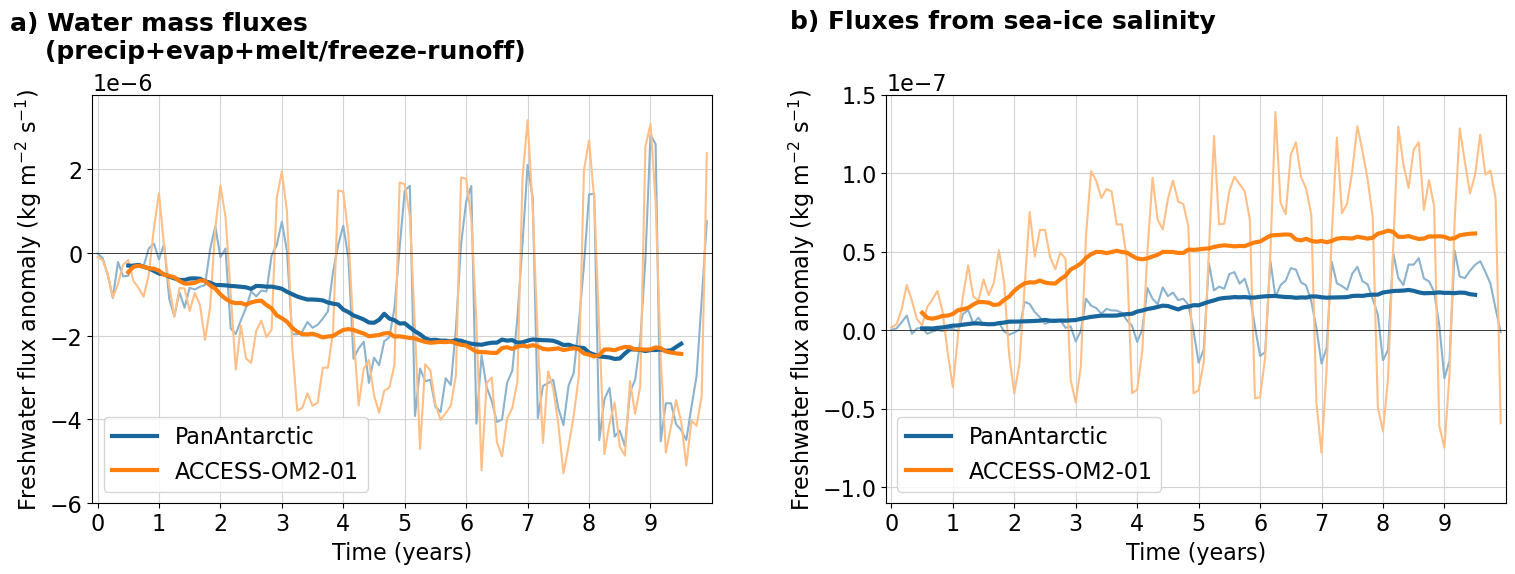

In [122]:
plt.rcParams['font.size'] = 16

# --- Create figure with 2 subplots side by side ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), constrained_layout=True)
fig.get_layout_engine().set(wspace=0.1) 

# =====================================================
# (a) Water mass flux anomalies (left panel)
# =====================================================
# Plot anomalies
ax1.plot((shelf_real_water_pan_M - shelf_real_water_pan_C).index,
         (shelf_real_water_pan_M - shelf_real_water_pan_C).values,
         color=lighten(colors['pan01_pre'], 0.5))
ax1.plot((shelf_real_water_acc_M - shelf_real_water_acc_C).index,
         (shelf_real_water_acc_M - shelf_real_water_acc_C).values,
         color=lighten(colors['access_pre'], 0.5))

# Plot rolling means
ax1.plot((shelf_real_water_pan_M_rm - shelf_real_water_pan_C_rm).index,
         (shelf_real_water_pan_M_rm - shelf_real_water_pan_C_rm).values,
         label='PanAntarctic', color=colors['pan01_pre'], linewidth=3)
ax1.plot((shelf_real_water_acc_M_rm - shelf_real_water_acc_C_rm).index,
         (shelf_real_water_acc_M_rm - shelf_real_water_acc_C_rm).values,
         label='ACCESS-OM2-01', color=colors['access_pre'], linewidth=3)

# Formatting
ax1.axhline(0, color='black', linewidth=0.5)
ax1.set_xticks(range(1, 121, 12))
ax1.set_xticklabels([str(i) for i in range(0, 10)])
ax1.set_xlim(0, 121)
ax1.set_ylim(-6e-6, 3.8e-6)
ax1.set_xlabel('Time (years)')
ax1.set_ylabel('Freshwater flux anomaly (kg m$^{-2}$ s$^{-1}$)')
ax1.legend(loc='lower left')
ax1.grid(True, color='lightgrey')

# =====================================================
# (b) Ice flux anomalies (right panel)
# =====================================================
# Plot anomalies
ax2.plot((shelf_ice_pan_M_new - shelf_ice_pan_C_new).index,
         (shelf_ice_pan_M_new - shelf_ice_pan_C_new).values,
         color=lighten(colors['pan01_pre'], 0.5))
ax2.plot((shelf_ice_acc_M_new - shelf_ice_acc_C_new).index,
         (shelf_ice_acc_M_new - shelf_ice_acc_C_new).values,
         color=lighten(colors['access_pre'], 0.5))

# Plot rolling means
ax2.plot((shelf_ice_pan_M_rm - shelf_ice_pan_C_rm).index,
         (shelf_ice_pan_M_rm - shelf_ice_pan_C_rm).values,
         label='PanAntarctic', color=colors['pan01_pre'], linewidth=3)
ax2.plot((shelf_ice_acc_M_rm - shelf_ice_acc_C_rm).index,
         (shelf_ice_acc_M_rm - shelf_ice_acc_C_rm).values,
         label='ACCESS-OM2-01', color=colors['access_pre'], linewidth=3)

# Formatting
ax2.legend(loc='lower left')
ax2.axhline(0, color='black', linewidth=0.5)
ax2.set_xticks(range(1, 121, 12))
ax2.set_xticklabels([str(i) for i in range(0, 10)])
ax2.set_xlim(0, 121)
ax2.set_ylim(-1.1e-7, 1.5e-7)
ax2.set_xlabel('Time (years)')
ax2.set_ylabel('Freshwater flux anomaly (kg m$^{-2}$ s$^{-1}$)')
ax2.grid(True, color='lightgrey')


fig.text(0, 1.02, 'a) Water mass fluxes\n    (precip+evap+melt/freeze-runoff)', fontsize=18, fontweight='bold')
fig.text(0.52, 1.08, 'b) Fluxes from sea-ice salinity', fontsize=18, fontweight='bold')

# --- Shared legend (optional) ---
handles, labels = ax2.get_legend_handles_labels()
#plt.tight_layout()
#fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.05, 0.5))
fig.savefig("/g/data/g40/kc5856/thesis_figures/intermodel_surfaceflux_water_ice.png", dpi=300, bbox_inches='tight')
plt.show()
